An updated worksheet for measuring the thickness of 2D materials using a microscope.

August 12 2020 version

See also https://arxiv.org/pdf/1303.3300.pdf and Dave Northeast's paper in MRX.

In [8]:
"""
importing modules
"""
import matplotlib.pyplot as plt
import numpy as np
import tmm as tmm
from tmm import color
import math
inf = math.inf
from scipy.interpolate import interp1d
import colorpy.illuminants
import colorpy.colormodels
from scipy.optimize import curve_fit
from pylab import *
%matplotlib notebook

import pandas as pd

In [15]:
    """
   Material definitions:  MoS2, Graphene, Aluminum, Silicon, Silicon dioxide, HBN, PDMS, air
   
   For each material an interpolating formula is created eg. MoS2_n_fn(wavelength in nm)= complex index at that wavelength
   
   MoS2, Si and Al data interpolated from literature.  Others assumed constant over the wavelengths of interest.
    """
    
MoS2_n_data= [ [400,3.69+3.14j],
                  [410,3.96+3.16j],
                  [420,4.13+3.16j],
                  [430,4.29+3.14j],
                  [440,4.53+3.14j],
                  [450,4.81+3.12j],
                  [460,5.18+2.98j],
                  [470,5.47+2.69j],
                  [480,5.55+2.29j],
                  [490,5.65+1.90j],
                  [500,5.62+1.59j],
                  [510,5.52+1.34j],
                  [520,5.37+1.22j],
                  [530,5.26+1.17j],
                  [540,5.16+1.14j],
                  [550,5.06+1.11j],
                  [560,4.97+1.01j],
                  [570,4.87+1.05j],
                  [580,4.81+1.10j],
                  [590,4.76+1.18j],
                  [600,4.81+1.34j],
                  [610,4.98+1.42j],
                  [620,5.18+1.29j],
                  [630,5.25+1.12j],
                  [640,5.16+0.99j],
                  [650,5.08+1.05j],
                  [660,5.07+1.19j],
                  [670,5.34+1.28j],
                  [680,5.71+1.09j],
                  [690,5.84+0.65j],
                  [700,5.69+0.42j],
                  [710,5.45+0.32j],
                  [720,5.29+0.21j],
                  [730,5.16+0.09j],
                  [740,5.07+0.02j],
                  [750,5.01+0.00j],
                  [760,4.95+0.00j],
                ]
                     
MoS2_n_data = np.array(MoS2_n_data)
MoS2_n_fn = interp1d(MoS2_n_data[:,0], MoS2_n_data[:,1], kind='linear')
    
Si_n_data = [[350, 5.48 + 3.00j],
                 [375, 6.70 + 1.4081j],
                 [387.5, 6.06 + 0.63j],
                 [400, 5.57 + 0.387j],
                 [425, 5.01 + 0.215j],
                 [450, 4.67 + 0.145j],
                 [475, 4.457 + 0.0943j],
                 [500, 4.30 + 7.28e-2j],
                 [525, 4.18 + 0.0555j],
                 [550, 4.08 + 4.06e-2j],
                 [575, 4.01 + 0.031j],
                 [600, 3.95 + 2.57e-2j],
                 [625, 3.897 + 0.02106j],
                 [650, 3.85 + 1.64e-2j],
                 [675, 3.815 + 0.01414j],
                 [700, 3.78 + 1.26e-2j],
                 [725, 3.757 + 0.01032j],
                 [750, 3.73 + 9.09e-3j],
                 [800, 3.69 + 6.54e-3j]]
Si_n_data = np.array(Si_n_data)
Si_n_fn = interp1d(Si_n_data[:,0], Si_n_data[:,1], kind='linear')
    
    # SiO2 refractive index (approximate): 1.46 regardless of wavelength
SiO2_n_fn = lambda wavelength : 1.46
    
PDMS_n_fn = lambda wavelength : 1.40
    
HBN_n_fn = lambda wavelength : 1.85  # note there is expected to be a slope to this.  find it later.
    
    # air refractive index
air_n_fn = lambda wavelength : 1
    
graphene_n_fn = lambda wavelength : 2.6+1.3j
    
al_optics = np.genfromtxt('aluminum_optics.csv', delimiter=',')
photon_energies=al_optics[:,0]
wavelengths=al_optics[:,1]/1e6
wavelengths=wavelengths * 1e9
al_n=al_optics[:,2]
al_k=al_optics[:,3]
n_al = al_n + al_k*1j
al_n_fn = interp1d(wavelengths,n_al,kind='linear')

t_graphene = 0.335
t_mos2 = 0.615
t_hbn = 0.33

In [7]:
def calc_transmittances(n_fn_list, d_list, th_0, pol='s', spectral_range='narrow'):
    """
    Calculate the transmission spectrum of a thin-film stack.  This is in exact analogy
    to the calc_reflectances from the tmm package, and is simply a slightly modified 
    version of that function.  The order of the materials is that the light comes FROM the
    first material in the list and is transmitted to the last material.
    
    n_fn_list[m] should be a function that inputs wavelength in nm and
    outputs refractive index of the m'th layer. In other words,
    n_fn_list[2](456) == 1.53 + 0.4j mans that layer #2 has a refractive index
    of 1.53 + 0.4j at 456nm. These functions could be defined with
    scipy.interpolate.interp1d() for example.
    
    pol, d_list and th_0 are defined as in tmm.coh_tmm ... but d_list
    MUST be in units of nanometers
    
    spectral_range can be 'full' if all the functions in n_fn_list can take
    wavelength arguments between 360-830nm; or 'narrow' if some or all require
    arguments only in the range 400-700nm. The wavelengths outside the
    'narrow' range make only a tiny difference to the color, because they are
    almost invisible to the eye. If spectral_range is 'narrow', then the n(400)
    values are used for 360-400 and n(700) for 700-830nm
    
    Returns a 2-column array where the first column is wavelength in nm
    (360,361,362,...,830) and the second column is reflectivity (from 0
    to 1, where 1 is a perfect mirror). This range is chosen to be
    consistent with colorpy.illuminants. See  colorpy.ciexyz.start_wl_nm etc.
    """
    
    lam_vac_list = arange(360, 831)
    
    num_layers = len(n_fn_list)
    
    def extend_spectral_range(n_fn):
        """
        Starting with a narrow-spectrum refractive index function
        n_fn(wavelength), create then return the corresponding full-spectrum
        refractive index function
        """
        def extended_n_fn(lam):
            if lam < 400:
                return n_fn(400)
            elif lam > 700:
                return n_fn(700)
            else:
                return n_fn(lam)
        return extended_n_fn
    
    if spectral_range == 'narrow':
        n_fn_list = [extend_spectral_range(n_fn) for n_fn in n_fn_list]
    
    final_answer = []
    
    for lam_vac in lam_vac_list:
        n_list = [n_fn_list[i](lam_vac) for i in range(num_layers)]
        T = tmm.coh_tmm(pol, n_list, d_list, th_0, lam_vac)['T']
        final_answer.append([lam_vac,T])
    final_answer = array(final_answer)

    return final_answer

<IPython.core.display.Javascript object>


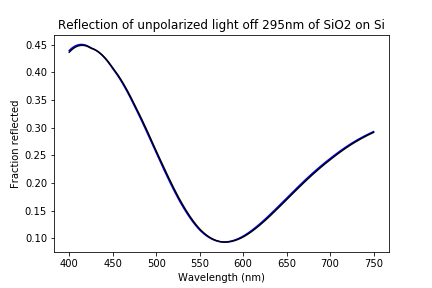

In [54]:
""" Plot reflectance of silicon/silicon dioxide, and with a monolayer of graphene
"""

    # list of layer thicknesses in nm
d_list = [inf,295,inf]

    # list of wavenumbers to plot in nm^-1
lamb=np.linspace(400,750,num=400)
    # initialize lists of y-values to plot
Rnorm=[]
    
    #reflectances = color.calc_reflectances(n_fn_list, d_list, th_0)
    
for l in lamb:
    n_list = [1,SiO2_n_fn(l),Si_n_fn(l)]
		# For normal incidence, s and p polarizations are identical.
		# I arbitrarily decided to use 's'.
    Rnorm.append(tmm.tmm_core.coh_tmm('s',n_list, d_list, 0, l)['R'])

    
    # list of layer thicknesses in nm
d_list = [inf,t_hbn,295,inf]

    # list of wavenumbers to plot in nm^-1
lamb=np.linspace(400,750,num=400)
    # initialize lists of y-values to plot
Rnormhbn=[]
    
    #reflectances = color.calc_reflectances(n_fn_list, d_list, th_0)
    
for l in lamb:
    n_list = [1,HBN_n_fn(l),SiO2_n_fn(l),Si_n_fn(l)]
		# For normal incidence, s and p polarizations are identical.
		# I arbitrarily decided to use 's'.
    Rnormhbn.append(tmm.tmm_core.coh_tmm('s',n_list, d_list, 0, l)['R'])    
plt.plot(lamb,Rnorm,'blue',lamb,Rnormhbn,'black')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Fraction reflected')
plt.title('Reflection of unpolarized light off 295nm of SiO2 on Si')

plt.show()



In [55]:
""" Reflectivity of SiO2/Si at the filter wavelengths"""

d_list = [inf,295,inf]
l_green = 500
l_yellow = 580

n_green = [1,SiO2_n_fn(l_green),Si_n_fn(l_green)]
n_yellow = [1,SiO2_n_fn(l_yellow),Si_n_fn(l_yellow)]

refl_green = tmm.tmm_core.coh_tmm('s',n_green, d_list, 0, l_green)['R']
refl_yellow = tmm.tmm_core.coh_tmm('s',n_yellow, d_list, 0, l_yellow)['R']

print("Green reflection of silicon/silicon dioxide is", refl_green)
print("Yellow reflection of silicon/silicon dioxide is", refl_yellow)


Green reflection of silicon/silicon dioxide is 0.25440125069716174
Yellow reflection of silicon/silicon dioxide is 0.0934447352597029


In [56]:
""" Reflectivity of a single monolayer of graphene on SiO2/Si at filter wavelengths"""

""" Reflectivity of SiO2/Si at the filter wavelengths"""

d_list = [inf,t_graphene,295,inf]
l_green = 500
l_yellow = 580

n_green = [1,HBN_n_fn(l_green),SiO2_n_fn(l_green),Si_n_fn(l_green)]
n_yellow = [1,HBN_n_fn(l_yellow),SiO2_n_fn(l_yellow),Si_n_fn(l_yellow)]

refl_stack_green = tmm.tmm_core.coh_tmm('s',n_green, d_list, 0, l_green)['R']
refl_stack_yellow = tmm.tmm_core.coh_tmm('s',n_yellow, d_list, 0, l_yellow)['R']

print("Green reflection of graphene/silicon/silicon dioxide is", refl_stack_green)
print("Yellow reflection of graphene/silicon/silicon dioxide is", refl_stack_yellow)

contrast_green = (refl_green-refl_stack_green)/refl_green
contrast_yellow = (refl_yellow-refl_stack_yellow)/refl_yellow

print("Green contrast of graphene/silicon/silicon dioxide is", contrast_green)
print("Yellow contrast of graphene/silicon/silicon dioxide is", contrast_yellow)

Green reflection of graphene/silicon/silicon dioxide is 0.25804514142225604
Yellow reflection of graphene/silicon/silicon dioxide is 0.09311122284150262
Green contrast of graphene/silicon/silicon dioxide is -0.01432339941375514
Yellow contrast of graphene/silicon/silicon dioxide is 0.003569087303563671


<IPython.core.display.Javascript object>


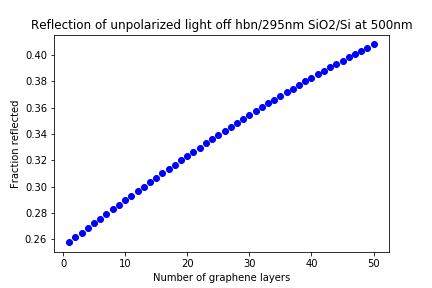

In [57]:
 # list of layer thicknesses in nm
    # list of refractive indices
n_green = [1,HBN_n_fn(l_green),SiO2_n_fn(l_green),Si_n_fn(l_green)]
    # list of wavenumbers to plot in nm^-1
layers=np.linspace(1,50,num=50)
    # initialize lists of y-values to plot
Rnorm=[]
Contrast=[]    
    #reflectances = color.calc_reflectances(n_fn_list, d_list, th_0)
    
for l in layers:
        d_list = [inf,t_hbn*l,295,inf]
		# For normal incidence, s and p polarizations are identical.
		# I arbitrarily decided to use 's'.
        refl = tmm.tmm_core.coh_tmm('s',n_green, d_list, 0, 500)['R']
        Rnorm.append(refl)
        Contrast.append((refl_green-refl)/refl_green)
   
plt.plot(layers,Rnorm,'bo')
plt.xlabel('Number of graphene layers')
plt.ylabel('Fraction reflected')
plt.title('Reflection of unpolarized light off hbn/295nm SiO2/Si at 500nm')
plt.show()

<IPython.core.display.Javascript object>


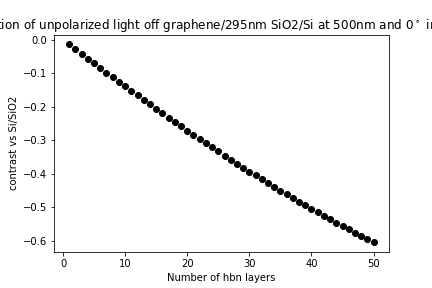

In [58]:
plt.plot(layers,Contrast,'ko')
plt.xlabel('Number of hbn layers')
plt.ylabel('contrast vs Si/SiO2')
plt.title('Reflection of unpolarized light off graphene/295nm SiO2/Si at 500nm and 0$^\circ$ incidence')
plt.show()

<IPython.core.display.Javascript object>


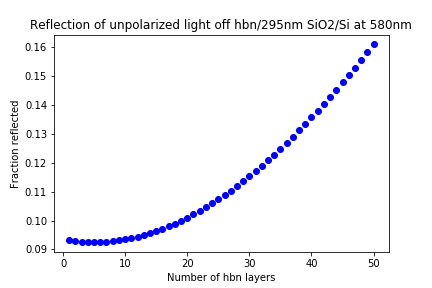

In [59]:
 # list of layer thicknesses in nm
    # list of refractive indices
n_green = [1,HBN_n_fn(l_yellow),SiO2_n_fn(l_yellow),Si_n_fn(l_yellow)]
    # list of wavenumbers to plot in nm^-1
layers=np.linspace(1,50,num=50)
    # initialize lists of y-values to plot
Rnorm=[]
Contrast=[]    
    #reflectances = color.calc_reflectances(n_fn_list, d_list, th_0)
    
for l in layers:
        d_list = [inf,t_hbn*l,295,inf]
		# For normal incidence, s and p polarizations are identical.
		# I arbitrarily decided to use 's'.
        refl = tmm.tmm_core.coh_tmm('s',n_yellow, d_list, 0, 580)['R']
        Rnorm.append(refl)
        Contrast.append((refl_yellow-refl)/refl_yellow)
   
plt.plot(layers,Rnorm,'bo')
plt.xlabel('Number of hbn layers')
plt.ylabel('Fraction reflected')
plt.title('Reflection of unpolarized light off hbn/295nm SiO2/Si at 580nm')
plt.show()

<IPython.core.display.Javascript object>


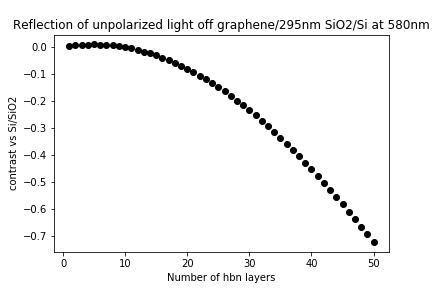

In [60]:
plt.plot(layers,Contrast,'ko')
plt.xlabel('Number of hbn layers')
plt.ylabel('contrast vs Si/SiO2')
plt.title('Reflection of unpolarized light off graphene/295nm SiO2/Si at 580nm')
plt.show()

<IPython.core.display.Javascript object>


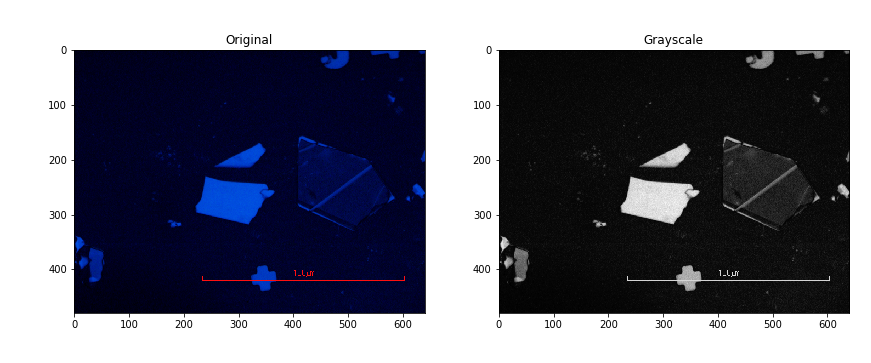

In [61]:
"""Now we need to import a figure, convert it to grayscale, and measure the contrast."""
from skimage import io
from skimage.color import rgb2gray

# read the image stack
img = io.imread('DSL30002.tif')
# show the image
grayscale = rgb2gray(img)

fig, axes = plt.subplots(1, 2)
ax = axes.ravel()

ax[0].imshow(img)
ax[0].set_title("Original")
ax[1].imshow(grayscale, cmap=plt.cm.gray)
ax[1].set_title("Grayscale")

fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


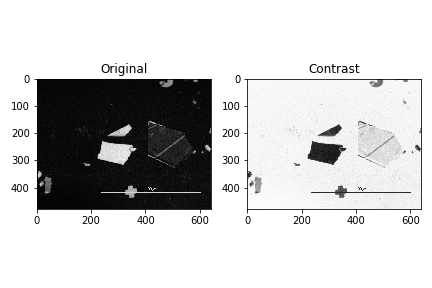

In [72]:
contrast_pic=(grayscale[0][0]-grayscale)/grayscale[0][0]
fig, axes = plt.subplots(1, 2)
ax = axes.ravel()

ax[0].imshow(grayscale,cmap=plt.cm.gray)
ax[0].set_title("Original")
ax[1].imshow(contrast_pic, cmap=plt.cm.gray)
ax[1].set_title("Contrast")

fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


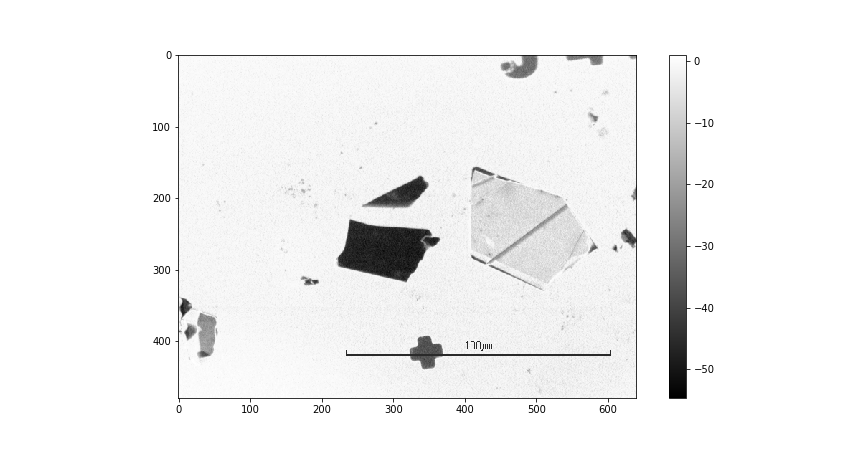

In [70]:
plt.imshow(contrast_pic,cmap=plt.cm.gray)
plt.colorbar()
plt.show()

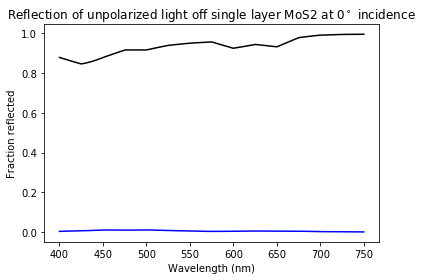

In [8]:
    """
    Plot the reflectivity of a single layer of graphene. 
    Plotting reflected intensity versus wavenumber, at two
    different incident angles.
    """
    
    MoS2_n_data= [[400,2.40+2.23j],
                  [425,3.32+2.23j],
                  [450,4.38+1.30j],
                  [475,4.49+0.85j],
                  [500,4.75+0.83j],
                  [525,4.50+0.65j],
                  [550,4.20+0.60j],
                  [575,3.82+0.62j],
                  [600,3.99+1.15j],
                  [625,4.42+0.75j],
                  [650,4.40+0.99j],
                  [675,4.50+0.25j],
                  [700,3.90+0.11j],
                  [725,3.56+0.07j],
                  [750,3.25+0.07j]]
    
    MoS2_n_data = np.array(MoS2_n_data)
    MoS2_n_fn = interp1d(MoS2_n_data[:,0], MoS2_n_data[:,1], kind='linear')
    
    # list of layer thicknesses in nm
    d_list = [inf,0.79,inf]
    # list of refractive indices

    # list of wavenumbers to plot in nm^-1
    lamb=np.linspace(400,750,num=400)
    # initialize lists of y-values to plot
    Rnorm=[]
    Tnorm=[]
    
    #reflectances = color.calc_reflectances(n_fn_list, d_list, th_0)
    
    for l in lamb:
        n_list = [1,MoS2_n_fn(l),1]
		# For normal incidence, s and p polarizations are identical.
		# I arbitrarily decided to use 's'.
        Rnorm.append(tmm.tmm_core.coh_tmm('s',n_list, d_list, 0, l)['R'])
        Tnorm.append(tmm.tmm_core.coh_tmm('s',n_list, d_list, 0, l)['T'])
    
   
    plt.plot(lamb,Rnorm,'blue',lamb,Tnorm,'black')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Fraction reflected')
    plt.title('Reflection of unpolarized light off single layer MoS2 at 0$^\circ$ incidence')
    plt.show()

In [62]:
print(grayscale)

[[0.0056549  0.00480667 0.00480667 ... 0.13553647 0.15210863 0.15043412]
 [0.00452392 0.00480667 0.00452392 ... 0.13805922 0.12403176 0.12405373]
 [0.00537216 0.0031102  0.00678588 ... 0.13638471 0.12346627 0.11422353]
 ...
 [0.00339294 0.00706863 0.00395843 ... 0.01661608 0.01437608 0.01074431]
 [0.00367569 0.00593765 0.00537216 ... 0.01746431 0.01494157 0.00961333]
 [0.00424118 0.0056549  0.00706863 ... 0.00961333 0.0087651  0.00763412]]


In [5]:
%matplotlib inline

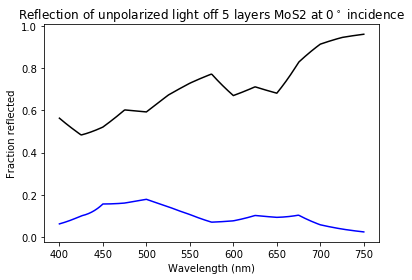

In [9]:
    """
    Plot the reflectivity of a single layer of graphene. 
    Plotting reflected intensity versus wavenumber, at two
    different incident angles.
    """
    
    MoS2_n_data= [[400,2.40+2.23j],
                  [425,3.32+2.23j],
                  [450,4.38+1.30j],
                  [475,4.49+0.85j],
                  [500,4.75+0.83j],
                  [525,4.50+0.65j],
                  [550,4.20+0.60j],
                  [575,3.82+0.62j],
                  [600,3.99+1.15j],
                  [625,4.42+0.75j],
                  [650,4.40+0.99j],
                  [675,4.50+0.25j],
                  [700,3.90+0.11j],
                  [725,3.56+0.07j],
                  [750,3.25+0.07j]]
    
    MoS2_n_data = np.array(MoS2_n_data)
    MoS2_n_fn = interp1d(MoS2_n_data[:,0], MoS2_n_data[:,1], kind='linear')
    
    # list of layer thicknesses in nm
    d_list = [inf,5*0.79,inf]
    # list of refractive indices

    # list of wavenumbers to plot in nm^-1
    lamb=np.linspace(400,750,num=400)
    # initialize lists of y-values to plot
    Rnorm=[]
    Tnorm=[]
    
    #reflectances = color.calc_reflectances(n_fn_list, d_list, th_0)
    
    for l in lamb:
        n_list = [1,MoS2_n_fn(l),1]
		# For normal incidence, s and p polarizations are identical.
		# I arbitrarily decided to use 's'.
        Rnorm.append(tmm.tmm_core.coh_tmm('s',n_list, d_list, 0, l)['R'])
        Tnorm.append(tmm.tmm_core.coh_tmm('s',n_list, d_list, 0, l)['T'])
    
   
    plt.plot(lamb,Rnorm,'blue',lamb,Tnorm,'black')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Fraction reflected')
    plt.title('Reflection of unpolarized light off 5 layers MoS2 at 0$^\circ$ incidence')
    plt.show()

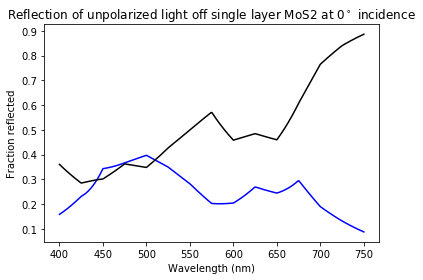

In [10]:
    """
    Plot the reflectivity of a single layer of graphene. 
    Plotting reflected intensity versus wavenumber, at two
    different incident angles.
    """
    
    MoS2_n_data= [[400,2.40+2.23j],
                  [425,3.32+2.23j],
                  [450,4.38+1.30j],
                  [475,4.49+0.85j],
                  [500,4.75+0.83j],
                  [525,4.50+0.65j],
                  [550,4.20+0.60j],
                  [575,3.82+0.62j],
                  [600,3.99+1.15j],
                  [625,4.42+0.75j],
                  [650,4.40+0.99j],
                  [675,4.50+0.25j],
                  [700,3.90+0.11j],
                  [725,3.56+0.07j],
                  [750,3.25+0.07j]]
    
    MoS2_n_data = np.array(MoS2_n_data)
    MoS2_n_fn = interp1d(MoS2_n_data[:,0], MoS2_n_data[:,1], kind='linear')
    
    # list of layer thicknesses in nm
    d_list = [inf,10*0.79,inf]
    # list of refractive indices

    # list of wavenumbers to plot in nm^-1
    lamb=np.linspace(400,750,num=400)
    # initialize lists of y-values to plot
    Rnorm=[]
    Tnorm=[]
    
    #reflectances = color.calc_reflectances(n_fn_list, d_list, th_0)
    
    for l in lamb:
        n_list = [1,MoS2_n_fn(l),1]
		# For normal incidence, s and p polarizations are identical.
		# I arbitrarily decided to use 's'.
        Rnorm.append(tmm.tmm_core.coh_tmm('s',n_list, d_list, 0, l)['R'])
        Tnorm.append(tmm.tmm_core.coh_tmm('s',n_list, d_list, 0, l)['T'])
    
   
    plt.plot(lamb,Rnorm,'blue',lamb,Tnorm,'black')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Fraction reflected')
    plt.title('Reflection of unpolarized light off single layer MoS2 at 0$^\circ$ incidence')
    plt.show()

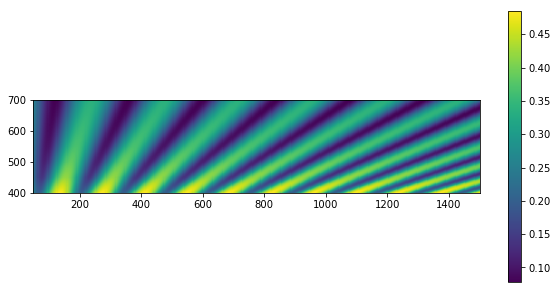

In [11]:
    """
    MoS2/SiO2/Si layer contrast - taken mostly from the above and example 5 of tmm.
    """
   
    # Crystalline silicon refractive index. Data from Palik via
    # http://refractiveindex.info, I haven't checked it, but this is just for
    # demonstration purposes anyway.
    Si_n_data = [[350, 5.48 + 3.00j],
                 [387.5, 6.06 + 0.63j],
                 [400, 5.57 + 0.387j],
                 [450, 4.67 + 0.145j],
                 [500, 4.30 + 7.28e-2j],
                 [550, 4.08 + 4.06e-2j],
                 [600, 3.95 + 2.57e-2j],
                 [650, 3.85 + 1.64e-2j],
                 [700, 3.78 + 1.26e-2j],
                 [750, 3.73 + 9.09e-3j],
                 [800, 3.69 + 6.54e-3j]]
    Si_n_data = np.array(Si_n_data)
    Si_n_fn = interp1d(Si_n_data[:,0], Si_n_data[:,1], kind='linear')
    
    MoS2_n_data= [[400,2.40+2.23j],
                  [425,3.32+2.23j],
                  [450,4.38+1.30j],
                  [475,4.49+0.85j],
                  [500,4.75+0.83j],
                  [525,4.50+0.65j],
                  [550,4.20+0.60j],
                  [575,3.82+0.62j],
                  [600,3.99+1.15j],
                  [625,4.42+0.75j],
                  [650,4.40+0.99j],
                  [675,4.50+0.25j],
                  [700,3.90+0.11j],
                  [725,3.56+0.07j],
                  [750,3.25+0.07j]]
    
    MoS2_n_data = np.array(MoS2_n_data)
    MoS2_n_fn = interp1d(MoS2_n_data[:,0], MoS2_n_data[:,1], kind='linear')
    # SiO2 refractive index (approximate): 1.46 regardless of wavelength
    SiO2_n_fn = lambda wavelength : 1.46
    # air refractive index
    air_n_fn = lambda wavelength : 1
    
    lamb=np.linspace(400,700,num=400)
    # initialize lists of y-values to plot
    Rnorm=[]
    R_gr_norm=[]
    contrast=[]
    
    
    sio2 = np.linspace(50,1500,num=401)
    
    TwoDR=np.zeros((400,401))
    TwoDRgr = np.zeros((400,401))
    TwoDcontrast = np.zeros((400,401))
    a=0
    b=0
    
    for s in sio2:
        b=0
        Rnorm=[]
        R_gr_norm=[]
        contrast=[]
        for l in lamb:
		# For normal incidence, s and p polarizations are identical.
		# I arbitrarily decided to use 's'.
            n_gr_list = [1,MoS2_n_fn(l),SiO2_n_fn(l),Si_n_fn(l)]
            n_list = [1,SiO2_n_fn(l),Si_n_fn(l)]
            d_gr_list= [inf,0.79,s,inf]
            d_list = [inf,s, inf]
            rn = tmm.tmm_core.coh_tmm('s',n_list, d_list, 0, l)['R']
            rg = tmm.tmm_core.coh_tmm('s',n_gr_list, d_gr_list, 0, l)['R']
            Rnorm.append(rn)
            R_gr_norm.append(rg)
            contrast.append((rn-rg)/rn)
            TwoDR[b,a]=rn
            TwoDRgr[b,a]=rg
            TwoDcontrast[b,a]=((rn-rg)/rn)
            b=b+1
            
        #   plt.plot(lamb,Rnorm,'black',lamb,R_gr_norm,'red')
        #   plt.xlabel('Wavelength (nm)')
        #   plt.ylabel('Fraction reflected')
        #   plt.title('thickness' )
        #   plt.show()
    
        # plt.plot(lamb,contrast,'black')
        # plt.xlabel('Wavelength (nm)')
        # plt.ylabel('Fractional contrast')
        # plt.title('Reflection of unpolarized light off heterostructure at 0$^\circ$ incidence')
        # plt.show()
        a=a+1
    plt.figure(figsize=(10,5))    
    plt.imshow(TwoDR, interpolation="nearest", origin="lower",extent=[50,1500,400,700])
    plt.colorbar()
    plt.show()

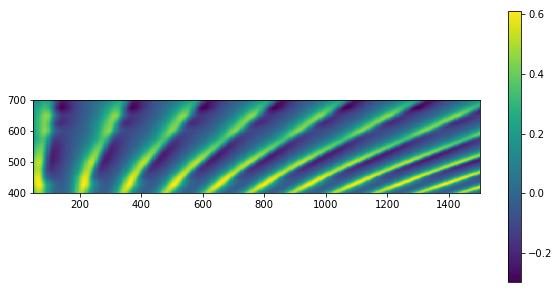

In [12]:
plt.figure(figsize=(10,5))
plt.subplot(111)
plt.imshow(TwoDcontrast, interpolation="nearest", origin="lower",extent=[50,1500,400,700])
plt.colorbar()
plt.show()

In [13]:
from scipy.optimize import curve_fit
from pylab import *

In [14]:
al_optics = np.genfromtxt('aluminum_optics.csv', delimiter=',')

In [15]:
al_optics[0]

array([  6.20000000e-03,   2.00000000e+02,   4.24000000e+02,
         4.84000000e+02,   9.96000000e-01])

In [16]:
photon_energies=al_optics[:,0]

In [17]:
wavelengths=al_optics[:,1]/1e6
wavelengths=wavelengths * 1e9
wavelengths

array([  2.00000000e+05,   1.77000000e+05,   1.54000000e+05,
         1.38000000e+05,   1.25000000e+05,   1.00000000e+05,
         8.00000000e+04,   6.67000000e+04,   5.71000000e+04,
         5.00000000e+04,   4.44000000e+04,   4.00000000e+04,
         3.33000000e+04,   3.10000000e+04,   2.76000000e+04,
         2.48000000e+04,   2.25000000e+04,   2.07000000e+04,
         1.91000000e+04,   1.77000000e+04,   1.55000000e+04,
         1.38000000e+04,   1.24000000e+04,   1.03000000e+04,
         8.86000000e+03,   7.75000000e+03,   6.89000000e+03,
         6.20000000e+03,   5.64000000e+03,   5.17000000e+03,
         4.77000000e+03,   4.43000000e+03,   4.13000000e+03,
         3.87000000e+03,   3.65000000e+03,   3.44000000e+03,
         3.26000000e+03,   3.10000000e+03,   2.76000000e+03,
         2.48000000e+03,   2.07000000e+03,   1.77000000e+03,
         1.55000000e+03,   1.38000000e+03,   1.24000000e+03,
         1.13000000e+03,   1.03000000e+03,   1.00000000e+03,
         9.69000000e+02,

In [18]:
al_n=al_optics[:,2]
al_k=al_optics[:,3]
n_al = al_n + al_k*1j
al_n_fn = interp1d(wavelengths,n_al,kind='linear')
al_n_fn(500)

array((0.8113750000000001+6.0445j))

Making color vs gap thickness graph. 


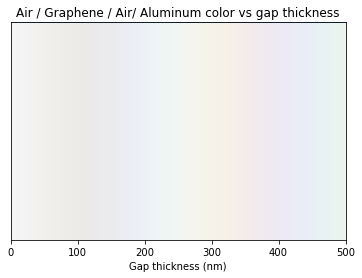

In [19]:
    """
    Color calculations: What color is a graphene / air / aluminum?
    """
    import colorpy.illuminants
    import colorpy.colormodels
    from tmm import color

    # SiO2 refractive index (approximate): 1.46 regardless of wavelength
    graphene_n_fn = lambda wavelength : 2.6+1.3j
    # air refractive index
    air_n_fn = lambda wavelength : 1
    
    n_fn_list = [air_n_fn, graphene_n_fn, air_n_fn, al_n_fn]
    th_0 = 0
    
    # Calculate irgb color (i.e. gamma-corrected sRGB display color rounded to
    # integers 0-255) versus thickness of SiO2
    max_gap_thickness = 500
    gap_thickness_list = linspace(0,max_gap_thickness,num=80)
    irgb_list = []
    for gap_d in gap_thickness_list:
        d_list = [inf, 0.34, gap_d, inf]
        reflectances = color.calc_reflectances(n_fn_list, d_list, th_0)
        illuminant = colorpy.illuminants.get_illuminant_D65()
        spectrum = color.calc_spectrum(reflectances, illuminant)
        color_dict = color.calc_color(spectrum)
        irgb_list.append(color_dict['irgb'])

    # Plot those colors
    print('Making color vs gap thickness graph. ')
    plt.figure()
    plt.plot([0,max_gap_thickness],[1,1])
    plt.xlim(0,max_gap_thickness)
    plt.ylim(0,1)
    plt.xlabel('Gap thickness (nm)')
    plt.yticks([])
    plt.title('Air / Graphene / Air/ Aluminum color vs gap thickness')
    for i in range(len(gap_thickness_list)):
        # One strip of each color, centered at x=SiO2_thickness_list[i]
        if i==0:
            x0 = 0
        else:
            x0 = (gap_thickness_list[i] + gap_thickness_list[i-1]) / 2
        if i == len(gap_thickness_list) - 1:
            x1 = max_gap_thickness
        else:
            x1 = (gap_thickness_list[i] + gap_thickness_list[i+1]) / 2
        y0 = 0
        y1 = 1
        poly_x = [x0,  x1,  x1, x0]
        poly_y = [y0, y0, y1, y1]
        color_string = colorpy.colormodels.irgb_string_from_irgb(irgb_list[i])
        plt.fill(poly_x, poly_y, color_string, edgecolor=color_string)

Making color vs gap thickness graph. 


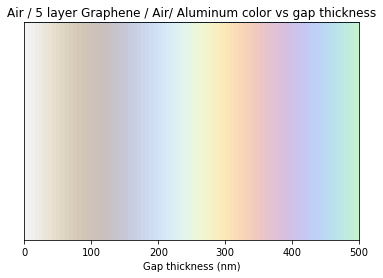

In [20]:
    max_gap_thickness = 500
    gap_thickness_list = linspace(0,max_gap_thickness,num=80)
    irgb_list = []
    for gap_d in gap_thickness_list:
        d_list = [inf, 5*0.34, gap_d, inf]
        reflectances = color.calc_reflectances(n_fn_list, d_list, th_0)
        illuminant = colorpy.illuminants.get_illuminant_D65()
        spectrum = color.calc_spectrum(reflectances, illuminant)
        color_dict = color.calc_color(spectrum)
        irgb_list.append(color_dict['irgb'])

    # Plot those colors
    print('Making color vs gap thickness graph. ')
    plt.figure()
    plt.plot([0,max_gap_thickness],[1,1])
    plt.xlim(0,max_gap_thickness)
    plt.ylim(0,1)
    plt.xlabel('Gap thickness (nm)')
    plt.yticks([])
    plt.title('Air / 5 layer Graphene / Air/ Aluminum color vs gap thickness')
    for i in range(len(gap_thickness_list)):
        # One strip of each color, centered at x=SiO2_thickness_list[i]
        if i==0:
            x0 = 0
        else:
            x0 = (gap_thickness_list[i] + gap_thickness_list[i-1]) / 2
        if i == len(gap_thickness_list) - 1:
            x1 = max_gap_thickness
        else:
            x1 = (gap_thickness_list[i] + gap_thickness_list[i+1]) / 2
        y0 = 0
        y1 = 1
        poly_x = [x0,  x1,  x1, x0]
        poly_y = [y0, y0, y1, y1]
        color_string = colorpy.colormodels.irgb_string_from_irgb(irgb_list[i])
        plt.fill(poly_x, poly_y, color_string, edgecolor=color_string)

Making color vs gap thickness graph. 


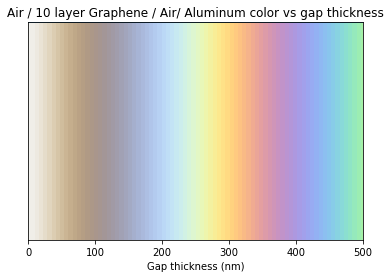

In [21]:
    max_gap_thickness = 500
    gap_thickness_list = linspace(0,max_gap_thickness,num=80)
    irgb_list = []
    for gap_d in gap_thickness_list:
        d_list = [inf, 10*0.34, gap_d, inf]
        reflectances = color.calc_reflectances(n_fn_list, d_list, th_0)
        illuminant = colorpy.illuminants.get_illuminant_D65()
        spectrum = color.calc_spectrum(reflectances, illuminant)
        color_dict = color.calc_color(spectrum)
        irgb_list.append(color_dict['irgb'])

    # Plot those colors
    print('Making color vs gap thickness graph. ')
    plt.figure()
    plt.plot([0,max_gap_thickness],[1,1])
    plt.xlim(0,max_gap_thickness)
    plt.ylim(0,1)
    plt.xlabel('Gap thickness (nm)')
    plt.yticks([])
    plt.title('Air / 10 layer Graphene / Air/ Aluminum color vs gap thickness')
    for i in range(len(gap_thickness_list)):
        # One strip of each color, centered at x=SiO2_thickness_list[i]
        if i==0:
            x0 = 0
        else:
            x0 = (gap_thickness_list[i] + gap_thickness_list[i-1]) / 2
        if i == len(gap_thickness_list) - 1:
            x1 = max_gap_thickness
        else:
            x1 = (gap_thickness_list[i] + gap_thickness_list[i+1]) / 2
        y0 = 0
        y1 = 1
        poly_x = [x0,  x1,  x1, x0]
        poly_y = [y0, y0, y1, y1]
        color_string = colorpy.colormodels.irgb_string_from_irgb(irgb_list[i])
        plt.fill(poly_x, poly_y, color_string, edgecolor=color_string)

Making color vs gap thickness graph. 


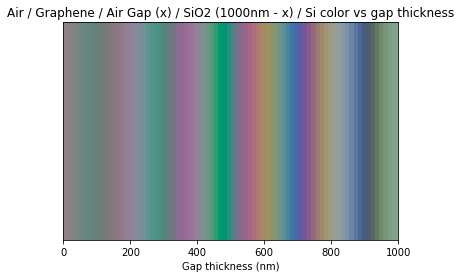

In [22]:
    """
    Color calculations: What color is a graphene / air / SiO2/ Si?  air/SiO2 layers trade off.
    """
    import colorpy.illuminants
    import colorpy.colormodels
    from tmm import color

    # Crystalline silicon refractive index. Data from Palik via
    # http://refractiveindex.info, I haven't checked it, but this is just for
    # demonstration purposes anyway.
    Si_n_data = [[400, 5.57 + 0.387j],
                 [450, 4.67 + 0.145j],
                 [500, 4.30 + 7.28e-2j],
                 [550, 4.08 + 4.06e-2j],
                 [600, 3.95 + 2.57e-2j],
                 [650, 3.85 + 1.64e-2j],
                 [700, 3.78 + 1.26e-2j]]
    Si_n_data = array(Si_n_data)
    Si_n_fn = interp1d(Si_n_data[:,0], Si_n_data[:,1], kind='linear')
    
    MoS2_n_data= [[400,2.40+2.23j],
                  [425,3.32+2.23j],
                  [450,4.38+1.30j],
                  [475,4.49+0.85j],
                  [500,4.75+0.83j],
                  [525,4.50+0.65j],
                  [550,4.20+0.60j],
                  [575,3.82+0.62j],
                  [600,3.99+1.15j],
                  [625,4.42+0.75j],
                  [650,4.40+0.99j],
                  [675,4.50+0.25j],
                  [700,3.90+0.11j],
                  [725,3.56+0.07j],
                  [750,3.25+0.07j]]
    
    MoS2_n_data = np.array(MoS2_n_data)
    MoS2_n_fn = interp1d(MoS2_n_data[:,0], MoS2_n_data[:,1], kind='linear')
    
    # SiO2 refractive index (approximate): 1.46 regardless of wavelength
    SiO2_n_fn = lambda wavelength : 1.46
    # air refractive index
    air_n_fn = lambda wavelength : 1
    
    n_fn_list = [air_n_fn, MoS2_n_fn, air_n_fn, SiO2_n_fn, Si_n_fn]
    th_0 = 0
    
    # Calculate irgb color (i.e. gamma-corrected sRGB display color rounded to
    # integers 0-255) versus thickness of SiO2
    max_gap_thickness = 1000
    gap_thickness_list = linspace(0,max_gap_thickness,num=80)
    irgb_list = []
    for gap_d in gap_thickness_list:
        d_list = [inf, 0.79, gap_d, 1000-gap_d, inf]
        reflectances = color.calc_reflectances(n_fn_list, d_list, th_0)
        illuminant = colorpy.illuminants.get_illuminant_D65()
        spectrum = color.calc_spectrum(reflectances, illuminant)
        color_dict = color.calc_color(spectrum)
        irgb_list.append(color_dict['irgb'])

    # Plot those colors
    print('Making color vs gap thickness graph. ')
    plt.figure()
    plt.plot([0,max_gap_thickness],[1,1])
    plt.xlim(0,max_gap_thickness)
    plt.ylim(0,1)
    plt.xlabel('Gap thickness (nm)')
    plt.yticks([])
    plt.title('Air / Graphene / Air Gap (x) / SiO2 (1000nm - x) / Si color vs gap thickness')
    for i in range(len(gap_thickness_list)):
        # One strip of each color, centered at x=SiO2_thickness_list[i]
        if i==0:
            x0 = 0
        else:
            x0 = (gap_thickness_list[i] + gap_thickness_list[i-1]) / 2
        if i == len(gap_thickness_list) - 1:
            x1 = max_gap_thickness
        else:
            x1 = (gap_thickness_list[i] + gap_thickness_list[i+1]) / 2
        y0 = 0
        y1 = 1
        poly_x = [x0,  x1,  x1, x0]
        poly_y = [y0, y0, y1, y1]
        color_string = colorpy.colormodels.irgb_string_from_irgb(irgb_list[i])
        plt.fill(poly_x, poly_y, color_string, edgecolor=color_string)

Making color vs gap thickness graph. 


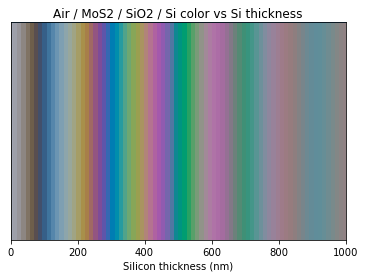

In [23]:
    """
    Color calculations: What color is a MoS2 / air / SiO2/ Si?  air/SiO2 layers trade off.
    """
    import colorpy.illuminants
    import colorpy.colormodels
    from tmm import color

    # Crystalline silicon refractive index. Data from Palik via
    # http://refractiveindex.info, I haven't checked it, but this is just for
    # demonstration purposes anyway.
    Si_n_data = [[400, 5.57 + 0.387j],
                 [450, 4.67 + 0.145j],
                 [500, 4.30 + 7.28e-2j],
                 [550, 4.08 + 4.06e-2j],
                 [600, 3.95 + 2.57e-2j],
                 [650, 3.85 + 1.64e-2j],
                 [700, 3.78 + 1.26e-2j]]
    Si_n_data = array(Si_n_data)
    Si_n_fn = interp1d(Si_n_data[:,0], Si_n_data[:,1], kind='linear')
    
    
    MoS2_n_data= [[400,2.40+2.23j],
                  [425,3.32+2.23j],
                  [450,4.38+1.30j],
                  [475,4.49+0.85j],
                  [500,4.75+0.83j],
                  [525,4.50+0.65j],
                  [550,4.20+0.60j],
                  [575,3.82+0.62j],
                  [600,3.99+1.15j],
                  [625,4.42+0.75j],
                  [650,4.40+0.99j],
                  [675,4.50+0.25j],
                  [700,3.90+0.11j],
                  [725,3.56+0.07j],
                  [750,3.25+0.07j]]
    
    MoS2_n_data = np.array(MoS2_n_data)
    MoS2_n_fn = interp1d(MoS2_n_data[:,0], MoS2_n_data[:,1], kind='linear')
    
    # SiO2 refractive index (approximate): 1.46 regardless of wavelength
    SiO2_n_fn = lambda wavelength : 1.46
    # air refractive index
    air_n_fn = lambda wavelength : 1
    
    n_fn_list = [air_n_fn, MoS2_n_fn, SiO2_n_fn, Si_n_fn]
    th_0 = 0
    
    # Calculate irgb color (i.e. gamma-corrected sRGB display color rounded to
    # integers 0-255) versus thickness of SiO2
    max_gap_thickness = 1000
    gap_thickness_list = linspace(0,max_gap_thickness,num=80)
    irgb_list = []
    for gap_d in gap_thickness_list:
        d_list = [inf, 0.79, gap_d, inf]
        reflectances = color.calc_reflectances(n_fn_list, d_list, th_0)
        illuminant = colorpy.illuminants.get_illuminant_D65()
        spectrum = color.calc_spectrum(reflectances, illuminant)
        color_dict = color.calc_color(spectrum)
        irgb_list.append(color_dict['irgb'])

    # Plot those colors
    print('Making color vs gap thickness graph. ')
    plt.figure()
    plt.plot([0,1000],[1,1])
    plt.xlim(0,1000)
    plt.ylim(0,1)
    plt.xlabel('Silicon thickness (nm)')
    plt.yticks([])
    plt.title('Air / MoS2 / SiO2 / Si color vs Si thickness')
    for i in range(len(gap_thickness_list)):
        # One strip of each color, centered at x=SiO2_thickness_list[i]
        if i==0:
            x0 = 0
        else:
            x0 = (gap_thickness_list[i] + gap_thickness_list[i-1]) / 2
        if i == len(gap_thickness_list) - 1:
            x1 = max_gap_thickness
        else:
            x1 = (gap_thickness_list[i] + gap_thickness_list[i+1]) / 2
        y0 = 0
        y1 = 1
        poly_x = [x0,  x1,  x1, x0]
        poly_y = [y0, y0, y1, y1]
        color_string = colorpy.colormodels.irgb_string_from_irgb(irgb_list[i])
        plt.fill(poly_x, poly_y, color_string, edgecolor=color_string)

Making color vs gap thickness graph. 


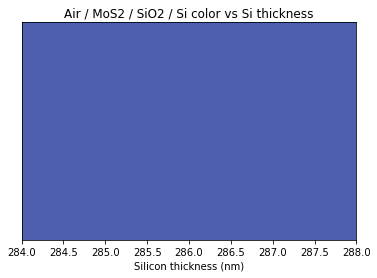

In [24]:
    """
    Color calculations: What color is a MoS2 / air / SiO2/ Si?  air/SiO2 layers trade off.
    """
    import colorpy.illuminants
    import colorpy.colormodels
    from tmm import color

    # Crystalline silicon refractive index. Data from Palik via
    # http://refractiveindex.info, I haven't checked it, but this is just for
    # demonstration purposes anyway.
    Si_n_data = [[400, 5.57 + 0.387j],
                 [450, 4.67 + 0.145j],
                 [500, 4.30 + 7.28e-2j],
                 [550, 4.08 + 4.06e-2j],
                 [600, 3.95 + 2.57e-2j],
                 [650, 3.85 + 1.64e-2j],
                 [700, 3.78 + 1.26e-2j]]
    Si_n_data = array(Si_n_data)
    Si_n_fn = interp1d(Si_n_data[:,0], Si_n_data[:,1], kind='linear')
    
    
    MoS2_n_data= [[400,2.40+2.23j],
                  [425,3.32+2.23j],
                  [450,4.38+1.30j],
                  [475,4.49+0.85j],
                  [500,4.75+0.83j],
                  [525,4.50+0.65j],
                  [550,4.20+0.60j],
                  [575,3.82+0.62j],
                  [600,3.99+1.15j],
                  [625,4.42+0.75j],
                  [650,4.40+0.99j],
                  [675,4.50+0.25j],
                  [700,3.90+0.11j],
                  [725,3.56+0.07j],
                  [750,3.25+0.07j]]
    
    MoS2_n_data = np.array(MoS2_n_data)
    MoS2_n_fn = interp1d(MoS2_n_data[:,0], MoS2_n_data[:,1], kind='linear')
    
    # SiO2 refractive index (approximate): 1.46 regardless of wavelength
    SiO2_n_fn = lambda wavelength : 1.46
    # air refractive index
    air_n_fn = lambda wavelength : 1
    
    n_fn_list = [air_n_fn, MoS2_n_fn, SiO2_n_fn, Si_n_fn]
    th_0 = 0
    
    # Calculate irgb color (i.e. gamma-corrected sRGB display color rounded to
    # integers 0-255) versus thickness of SiO2
    max_gap_thickness = 1000
    gap_thickness_list = linspace(0,max_gap_thickness,num=200)
    irgb_list = []
    for gap_d in gap_thickness_list:
        d_list = [inf, 0.615, gap_d, inf]
        reflectances = color.calc_reflectances(n_fn_list, d_list, th_0)
        illuminant = colorpy.illuminants.get_illuminant_D65()
        spectrum = color.calc_spectrum(reflectances, illuminant)
        color_dict = color.calc_color(spectrum)
        irgb_list.append(color_dict['irgb'])

    # Plot those colors
    print('Making color vs gap thickness graph. ')
    plt.figure()
    plt.plot([0,1000],[1,1])
    plt.xlim(284,288)
    plt.ylim(0,1)
    plt.xlabel('Silicon thickness (nm)')
    plt.yticks([])
    plt.title('Air / MoS2 / SiO2 / Si color vs Si thickness')
    for i in range(len(gap_thickness_list)):
        # One strip of each color, centered at x=SiO2_thickness_list[i]
        if i==0:
            x0 = 0
        else:
            x0 = (gap_thickness_list[i] + gap_thickness_list[i-1]) / 2
        if i == len(gap_thickness_list) - 1:
            x1 = max_gap_thickness
        else:
            x1 = (gap_thickness_list[i] + gap_thickness_list[i+1]) / 2
        y0 = 0
        y1 = 1
        poly_x = [x0,  x1,  x1, x0]
        poly_y = [y0, y0, y1, y1]
        color_string = colorpy.colormodels.irgb_string_from_irgb(irgb_list[i])
        plt.fill(poly_x, poly_y, color_string, edgecolor=color_string)

Making color vs gap thickness graph. 


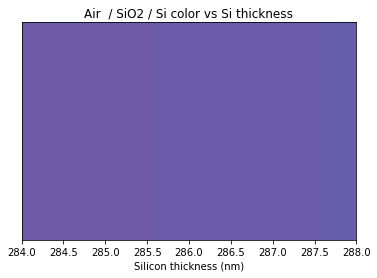

In [44]:
    """
    Color calculations: What color is a air / SiO2/ Si?  air/SiO2 layers trade off.
    """
    import colorpy.illuminants
    import colorpy.colormodels
    from tmm import color

    # Crystalline silicon refractive index. Data from Palik via
    # http://refractiveindex.info, I haven't checked it, but this is just for
    # demonstration purposes anyway.
    Si_n_data = [[400, 5.57 + 0.387j],
                 [450, 4.67 + 0.145j],
                 [500, 4.30 + 7.28e-2j],
                 [550, 4.08 + 4.06e-2j],
                 [600, 3.95 + 2.57e-2j],
                 [650, 3.85 + 1.64e-2j],
                 [700, 3.78 + 1.26e-2j]]
    Si_n_data = array(Si_n_data)
    Si_n_fn = interp1d(Si_n_data[:,0], Si_n_data[:,1], kind='linear')
    
    
    MoS2_n_data= [[400,2.40+2.23j],
                  [425,3.32+2.23j],
                  [450,4.38+1.30j],
                  [475,4.49+0.85j],
                  [500,4.75+0.83j],
                  [525,4.50+0.65j],
                  [550,4.20+0.60j],
                  [575,3.82+0.62j],
                  [600,3.99+1.15j],
                  [625,4.42+0.75j],
                  [650,4.40+0.99j],
                  [675,4.50+0.25j],
                  [700,3.90+0.11j],
                  [725,3.56+0.07j],
                  [750,3.25+0.07j]]
    
    MoS2_n_data = np.array(MoS2_n_data)
    MoS2_n_fn = interp1d(MoS2_n_data[:,0], MoS2_n_data[:,1], kind='linear')
    
    # SiO2 refractive index (approximate): 1.46 regardless of wavelength
    SiO2_n_fn = lambda wavelength : 1.46
    # air refractive index
    air_n_fn = lambda wavelength : 1
    
    n_fn_list = [air_n_fn, SiO2_n_fn, Si_n_fn]
    th_0 = 0
    
    # Calculate irgb color (i.e. gamma-corrected sRGB display color rounded to
    # integers 0-255) versus thickness of SiO2
    max_gap_thickness = 1000
    gap_thickness_list = linspace(0,max_gap_thickness,num=500)
    irgb_list = []
    for gap_d in gap_thickness_list:
        d_list = [inf, gap_d, inf]
        reflectances = color.calc_reflectances(n_fn_list, d_list, th_0)
        illuminant = colorpy.illuminants.get_illuminant_D65()
        spectrum = color.calc_spectrum(reflectances, illuminant)
        color_dict = color.calc_color(spectrum)
        irgb_list.append(color_dict['irgb'])

    # Plot those colors
    print('Making color vs gap thickness graph. ')
    plt.figure()
    plt.plot([0,1000],[1,1])
    plt.xlim(284,288)
    plt.ylim(0,1)
    plt.xlabel('Silicon thickness (nm)')
    plt.yticks([])
    plt.title('Air  / SiO2 / Si color vs Si thickness')
    for i in range(len(gap_thickness_list)):
        # One strip of each color, centered at x=SiO2_thickness_list[i]
        if i==0:
            x0 = 0
        else:
            x0 = (gap_thickness_list[i] + gap_thickness_list[i-1]) / 2
        if i == len(gap_thickness_list) - 1:
            x1 = max_gap_thickness
        else:
            x1 = (gap_thickness_list[i] + gap_thickness_list[i+1]) / 2
        y0 = 0
        y1 = 1
        poly_x = [x0,  x1,  x1, x0]
        poly_y = [y0, y0, y1, y1]
        color_string = colorpy.colormodels.irgb_string_from_irgb(irgb_list[i])
        plt.fill(poly_x, poly_y, color_string, edgecolor=color_string)

Making color vs gap thickness graph. 


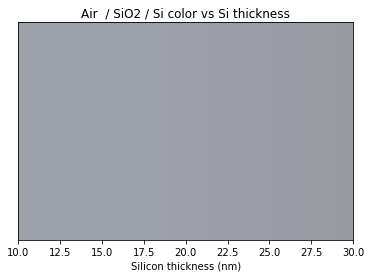

In [47]:
    """
    Color calculations: What color is a air / SiO2/ Si?  air/SiO2 layers trade off.
    """
    import colorpy.illuminants
    import colorpy.colormodels
    from tmm import color

    # Crystalline silicon refractive index. Data from Palik via
    # http://refractiveindex.info, I haven't checked it, but this is just for
    # demonstration purposes anyway.
    Si_n_data = [[400, 5.57 + 0.387j],
                 [450, 4.67 + 0.145j],
                 [500, 4.30 + 7.28e-2j],
                 [550, 4.08 + 4.06e-2j],
                 [600, 3.95 + 2.57e-2j],
                 [650, 3.85 + 1.64e-2j],
                 [700, 3.78 + 1.26e-2j]]
    Si_n_data = array(Si_n_data)
    Si_n_fn = interp1d(Si_n_data[:,0], Si_n_data[:,1], kind='linear')
    
    
    MoS2_n_data= [[400,2.40+2.23j],
                  [425,3.32+2.23j],
                  [450,4.38+1.30j],
                  [475,4.49+0.85j],
                  [500,4.75+0.83j],
                  [525,4.50+0.65j],
                  [550,4.20+0.60j],
                  [575,3.82+0.62j],
                  [600,3.99+1.15j],
                  [625,4.42+0.75j],
                  [650,4.40+0.99j],
                  [675,4.50+0.25j],
                  [700,3.90+0.11j],
                  [725,3.56+0.07j],
                  [750,3.25+0.07j]]
    
    MoS2_n_data = np.array(MoS2_n_data)
    MoS2_n_fn = interp1d(MoS2_n_data[:,0], MoS2_n_data[:,1], kind='linear')
    
    # SiO2 refractive index (approximate): 1.46 regardless of wavelength
    SiO2_n_fn = lambda wavelength : 1.46
    # air refractive index
    air_n_fn = lambda wavelength : 1
    
    n_fn_list = [air_n_fn, SiO2_n_fn, Si_n_fn]
    th_0 = 0
    
    # Calculate irgb color (i.e. gamma-corrected sRGB display color rounded to
    # integers 0-255) versus thickness of SiO2
    max_gap_thickness = 1000
    gap_thickness_list = linspace(0,max_gap_thickness,num=500)
    irgb_list = []
    for gap_d in gap_thickness_list:
        d_list = [inf, gap_d, inf]
        reflectances = color.calc_reflectances(n_fn_list, d_list, th_0)
        illuminant = colorpy.illuminants.get_illuminant_D65()
        spectrum = color.calc_spectrum(reflectances, illuminant)
        color_dict = color.calc_color(spectrum)
        irgb_list.append(color_dict['irgb'])

    # Plot those colors
    print('Making color vs gap thickness graph. ')
    plt.figure()
    plt.plot([0,1000],[1,1])
    plt.xlim(10,30)
    plt.ylim(0,1)
    plt.xlabel('Silicon thickness (nm)')
    plt.yticks([])
    plt.title('Air  / SiO2 / Si color vs Si thickness')
    for i in range(len(gap_thickness_list)):
        # One strip of each color, centered at x=SiO2_thickness_list[i]
        if i==0:
            x0 = 0
        else:
            x0 = (gap_thickness_list[i] + gap_thickness_list[i-1]) / 2
        if i == len(gap_thickness_list) - 1:
            x1 = max_gap_thickness
        else:
            x1 = (gap_thickness_list[i] + gap_thickness_list[i+1]) / 2
        y0 = 0
        y1 = 1
        poly_x = [x0,  x1,  x1, x0]
        poly_y = [y0, y0, y1, y1]
        color_string = colorpy.colormodels.irgb_string_from_irgb(irgb_list[i])
        plt.fill(poly_x, poly_y, color_string, edgecolor=color_string)

Making color vs gap thickness graph. 


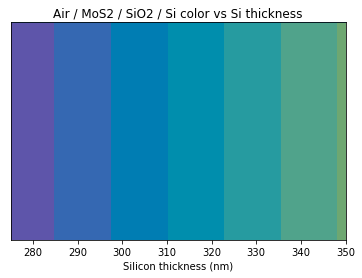

In [26]:
    """
    Color calculations: What color is a MoS2 / air / SiO2/ Si?  air/SiO2 layers trade off.
    """
    import colorpy.illuminants
    import colorpy.colormodels
    from tmm import color

    # Crystalline silicon refractive index. Data from Palik via
    # http://refractiveindex.info, I haven't checked it, but this is just for
    # demonstration purposes anyway.
    Si_n_data = [[400, 5.57 + 0.387j],
                 [450, 4.67 + 0.145j],
                 [500, 4.30 + 7.28e-2j],
                 [550, 4.08 + 4.06e-2j],
                 [600, 3.95 + 2.57e-2j],
                 [650, 3.85 + 1.64e-2j],
                 [700, 3.78 + 1.26e-2j]]
    Si_n_data = array(Si_n_data)
    Si_n_fn = interp1d(Si_n_data[:,0], Si_n_data[:,1], kind='linear')
    
    
    MoS2_n_data= [[400,2.40+2.23j],
                  [425,3.32+2.23j],
                  [450,4.38+1.30j],
                  [475,4.49+0.85j],
                  [500,4.75+0.83j],
                  [525,4.50+0.65j],
                  [550,4.20+0.60j],
                  [575,3.82+0.62j],
                  [600,3.99+1.15j],
                  [625,4.42+0.75j],
                  [650,4.40+0.99j],
                  [675,4.50+0.25j],
                  [700,3.90+0.11j],
                  [725,3.56+0.07j],
                  [750,3.25+0.07j]]
    
    MoS2_n_data = np.array(MoS2_n_data)
    MoS2_n_fn = interp1d(MoS2_n_data[:,0], MoS2_n_data[:,1], kind='linear')
    
    # SiO2 refractive index (approximate): 1.46 regardless of wavelength
    SiO2_n_fn = lambda wavelength : 1.46
    # air refractive index
    air_n_fn = lambda wavelength : 1
    
    n_fn_list = [air_n_fn, MoS2_n_fn, SiO2_n_fn, Si_n_fn]
    th_0 = 0
    
    # Calculate irgb color (i.e. gamma-corrected sRGB display color rounded to
    # integers 0-255) versus thickness of SiO2
    max_gap_thickness = 1000
    gap_thickness_list = linspace(0,max_gap_thickness,num=80)
    irgb_list = []
    for gap_d in gap_thickness_list:
        d_list = [inf, 0.79, gap_d, inf]
        reflectances = color.calc_reflectances(n_fn_list, d_list, th_0)
        illuminant = colorpy.illuminants.get_illuminant_D65()
        spectrum = color.calc_spectrum(reflectances, illuminant)
        color_dict = color.calc_color(spectrum)
        irgb_list.append(color_dict['irgb'])

    # Plot those colors
    print('Making color vs gap thickness graph. ')
    plt.figure()
    plt.plot([0,1000],[1,1])
    plt.xlim(275,350)
    plt.ylim(0,1)
    plt.xlabel('Silicon thickness (nm)')
    plt.yticks([])
    plt.title('Air / MoS2 / SiO2 / Si color vs Si thickness')
    for i in range(len(gap_thickness_list)):
        # One strip of each color, centered at x=SiO2_thickness_list[i]
        if i==0:
            x0 = 0
        else:
            x0 = (gap_thickness_list[i] + gap_thickness_list[i-1]) / 2
        if i == len(gap_thickness_list) - 1:
            x1 = max_gap_thickness
        else:
            x1 = (gap_thickness_list[i] + gap_thickness_list[i+1]) / 2
        y0 = 0
        y1 = 1
        poly_x = [x0,  x1,  x1, x0]
        poly_y = [y0, y0, y1, y1]
        color_string = colorpy.colormodels.irgb_string_from_irgb(irgb_list[i])
        plt.fill(poly_x, poly_y, color_string, edgecolor=color_string)

Making color vs gap thickness graph. 


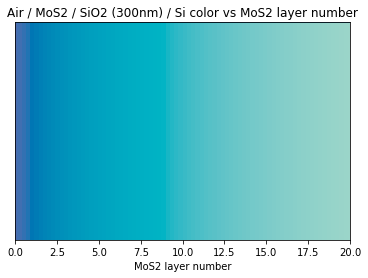

In [27]:
    """
    Color calculations: What color is a graphene / air / SiO2/ Si?  air/SiO2 layers trade off.
    """
    import colorpy.illuminants
    import colorpy.colormodels
    from tmm import color

    # Crystalline silicon refractive index. Data from Palik via
    # http://refractiveindex.info, I haven't checked it, but this is just for
    # demonstration purposes anyway.
    Si_n_data = [[400, 5.57 + 0.387j],
                 [450, 4.67 + 0.145j],
                 [500, 4.30 + 7.28e-2j],
                 [550, 4.08 + 4.06e-2j],
                 [600, 3.95 + 2.57e-2j],
                 [650, 3.85 + 1.64e-2j],
                 [700, 3.78 + 1.26e-2j]]
    Si_n_data = array(Si_n_data)
    Si_n_fn = interp1d(Si_n_data[:,0], Si_n_data[:,1], kind='linear')
    
    MoS2_n_data= [[400,2.40+2.23j],
                  [425,3.32+2.23j],
                  [450,4.38+1.30j],
                  [475,4.49+0.85j],
                  [500,4.75+0.83j],
                  [525,4.50+0.65j],
                  [550,4.20+0.60j],
                  [575,3.82+0.62j],
                  [600,3.99+1.15j],
                  [625,4.42+0.75j],
                  [650,4.40+0.99j],
                  [675,4.50+0.25j],
                  [700,3.90+0.11j],
                  [725,3.56+0.07j],
                  [750,3.25+0.07j]]
    
    MoS2_n_data = np.array(MoS2_n_data)
    MoS2_n_fn = interp1d(MoS2_n_data[:,0], MoS2_n_data[:,1], kind='linear')
    
    # SiO2 refractive index (approximate): 1.46 regardless of wavelength
    SiO2_n_fn = lambda wavelength : 1.46
    # air refractive index
    air_n_fn = lambda wavelength : 1
    
    n_fn_list = [air_n_fn, MoS2_n_fn, SiO2_n_fn, Si_n_fn]
    th_0 = 0
    
    # Calculate irgb color (i.e. gamma-corrected sRGB display color rounded to
    # integers 0-255) versus thickness of SiO2
    max_gap_thickness = 20
    gap_thickness_list = linspace(0,max_gap_thickness,num=80)
    irgb_list = []
    for gap_d in gap_thickness_list:
        d_list = [inf, gap_d*0.79, 300, inf]
        reflectances = color.calc_reflectances(n_fn_list, d_list, th_0)
        illuminant = colorpy.illuminants.get_illuminant_D65()
        spectrum = color.calc_spectrum(reflectances, illuminant)
        color_dict = color.calc_color(spectrum)
        irgb_list.append(color_dict['irgb'])

    # Plot those colors
    print('Making color vs gap thickness graph. ')
    plt.figure()
    plt.plot([0,max_gap_thickness],[1,1])
    plt.xlim(0,max_gap_thickness)
    plt.ylim(0,1)
    plt.xlabel('MoS2 layer number')
    plt.yticks([])
    plt.title('Air / MoS2 / SiO2 (300nm) / Si color vs MoS2 layer number')
    for i in range(len(gap_thickness_list)):
        # One strip of each color, centered at x=SiO2_thickness_list[i]
        if i==0:
            x0 = 0
        else:
            x0 = (gap_thickness_list[i] + gap_thickness_list[i-1]) / 2
        if i == len(gap_thickness_list) - 1:
            x1 = max_gap_thickness
        else:
            x1 = (gap_thickness_list[i] + gap_thickness_list[i+1]) / 2
        y0 = 0
        y1 = 1
        poly_x = [x0,  x1,  x1, x0]
        poly_y = [y0, y0, y1, y1]
        color_string = colorpy.colormodels.irgb_string_from_irgb(irgb_list[i])
        plt.fill(poly_x, poly_y, color_string, edgecolor=color_string)

Making color vs gap thickness graph. 


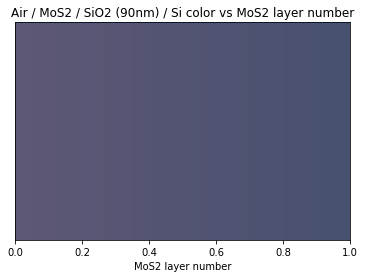

In [46]:
    """
    Color calculations: What color is a graphene / air / SiO2/ Si?  air/SiO2 layers trade off.
    """
    import colorpy.illuminants
    import colorpy.colormodels
    from tmm import color

    # Crystalline silicon refractive index. Data from Palik via
    # http://refractiveindex.info, I haven't checked it, but this is just for
    # demonstration purposes anyway.
    Si_n_data = [[400, 5.57 + 0.387j],
                 [450, 4.67 + 0.145j],
                 [500, 4.30 + 7.28e-2j],
                 [550, 4.08 + 4.06e-2j],
                 [600, 3.95 + 2.57e-2j],
                 [650, 3.85 + 1.64e-2j],
                 [700, 3.78 + 1.26e-2j]]
    Si_n_data = array(Si_n_data)
    Si_n_fn = interp1d(Si_n_data[:,0], Si_n_data[:,1], kind='linear')
    
    MoS2_n_data= [[400,2.40+2.23j],
                  [425,3.32+2.23j],
                  [450,4.38+1.30j],
                  [475,4.49+0.85j],
                  [500,4.75+0.83j],
                  [525,4.50+0.65j],
                  [550,4.20+0.60j],
                  [575,3.82+0.62j],
                  [600,3.99+1.15j],
                  [625,4.42+0.75j],
                  [650,4.40+0.99j],
                  [675,4.50+0.25j],
                  [700,3.90+0.11j],
                  [725,3.56+0.07j],
                  [750,3.25+0.07j]]
    
    MoS2_n_data = np.array(MoS2_n_data)
    MoS2_n_fn = interp1d(MoS2_n_data[:,0], MoS2_n_data[:,1], kind='linear')
    
    # SiO2 refractive index (approximate): 1.46 regardless of wavelength
    SiO2_n_fn = lambda wavelength : 1.46
    # air refractive index
    air_n_fn = lambda wavelength : 1
    
    n_fn_list = [air_n_fn, MoS2_n_fn, SiO2_n_fn, Si_n_fn]
    th_0 = 0
    
    # Calculate irgb color (i.e. gamma-corrected sRGB display color rounded to
    # integers 0-255) versus thickness of SiO2
    max_gap_thickness = 1
    gap_thickness_list = linspace(0,max_gap_thickness,num=80)
    irgb_list = []
    for gap_d in gap_thickness_list:
        d_list = [inf, gap_d*0.615, 90, inf]
        reflectances = color.calc_reflectances(n_fn_list, d_list, th_0)
        illuminant = colorpy.illuminants.get_illuminant_D65()
        spectrum = color.calc_spectrum(reflectances, illuminant)
        color_dict = color.calc_color(spectrum)
        irgb_list.append(color_dict['irgb'])

    # Plot those colors
    print('Making color vs gap thickness graph. ')
    plt.figure()
    plt.plot([0,max_gap_thickness],[1,1])
    plt.xlim(0,max_gap_thickness)
    plt.ylim(0,1)
    plt.xlabel('MoS2 layer number')
    plt.yticks([])
    plt.title('Air / MoS2 / SiO2 (90nm) / Si color vs MoS2 layer number')
    for i in range(len(gap_thickness_list)):
        # One strip of each color, centered at x=SiO2_thickness_list[i]
        if i==0:
            x0 = 0
        else:
            x0 = (gap_thickness_list[i] + gap_thickness_list[i-1]) / 2
        if i == len(gap_thickness_list) - 1:
            x1 = max_gap_thickness
        else:
            x1 = (gap_thickness_list[i] + gap_thickness_list[i+1]) / 2
        y0 = 0
        y1 = 1
        poly_x = [x0,  x1,  x1, x0]
        poly_y = [y0, y0, y1, y1]
        color_string = colorpy.colormodels.irgb_string_from_irgb(irgb_list[i])
        plt.fill(poly_x, poly_y, color_string, edgecolor=color_string)

Making color vs gap thickness graph. 


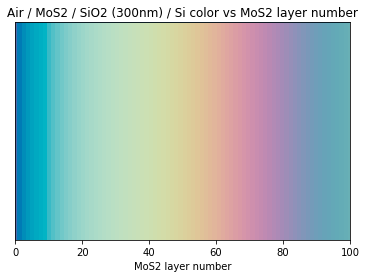

In [29]:
    """
    Color calculations: What color is a graphene / air / SiO2/ Si?  air/SiO2 layers trade off.
    """
    import colorpy.illuminants
    import colorpy.colormodels
    from tmm import color

    # Crystalline silicon refractive index. Data from Palik via
    # http://refractiveindex.info, I haven't checked it, but this is just for
    # demonstration purposes anyway.
    Si_n_data = [[400, 5.57 + 0.387j],
                 [450, 4.67 + 0.145j],
                 [500, 4.30 + 7.28e-2j],
                 [550, 4.08 + 4.06e-2j],
                 [600, 3.95 + 2.57e-2j],
                 [650, 3.85 + 1.64e-2j],
                 [700, 3.78 + 1.26e-2j]]
    Si_n_data = array(Si_n_data)
    Si_n_fn = interp1d(Si_n_data[:,0], Si_n_data[:,1], kind='linear')
    
    MoS2_n_data= [[400,2.40+2.23j],
                  [425,3.32+2.23j],
                  [450,4.38+1.30j],
                  [475,4.49+0.85j],
                  [500,4.75+0.83j],
                  [525,4.50+0.65j],
                  [550,4.20+0.60j],
                  [575,3.82+0.62j],
                  [600,3.99+1.15j],
                  [625,4.42+0.75j],
                  [650,4.40+0.99j],
                  [675,4.50+0.25j],
                  [700,3.90+0.11j],
                  [725,3.56+0.07j],
                  [750,3.25+0.07j]]
    
    MoS2_n_data = np.array(MoS2_n_data)
    MoS2_n_fn = interp1d(MoS2_n_data[:,0], MoS2_n_data[:,1], kind='linear')
    
    # SiO2 refractive index (approximate): 1.46 regardless of wavelength
    SiO2_n_fn = lambda wavelength : 1.46
    # air refractive index
    air_n_fn = lambda wavelength : 1
    
    n_fn_list = [air_n_fn, MoS2_n_fn, SiO2_n_fn, Si_n_fn]
    th_0 = 0
    
    # Calculate irgb color (i.e. gamma-corrected sRGB display color rounded to
    # integers 0-255) versus thickness of SiO2
    max_gap_thickness = 100
    gap_thickness_list = linspace(0,max_gap_thickness,num=80)
    irgb_list = []
    for gap_d in gap_thickness_list:
        d_list = [inf, gap_d*0.79, 300, inf]
        reflectances = color.calc_reflectances(n_fn_list, d_list, th_0)
        illuminant = colorpy.illuminants.get_illuminant_D65()
        spectrum = color.calc_spectrum(reflectances, illuminant)
        color_dict = color.calc_color(spectrum)
        irgb_list.append(color_dict['irgb'])

    # Plot those colors
    print('Making color vs gap thickness graph. ')
    plt.figure()
    plt.plot([0,max_gap_thickness],[1,1])
    plt.xlim(0,max_gap_thickness)
    plt.ylim(0,1)
    plt.xlabel('MoS2 layer number')
    plt.yticks([])
    plt.title('Air / MoS2 / SiO2 (300nm) / Si color vs MoS2 layer number')
    for i in range(len(gap_thickness_list)):
        # One strip of each color, centered at x=SiO2_thickness_list[i]
        if i==0:
            x0 = 0
        else:
            x0 = (gap_thickness_list[i] + gap_thickness_list[i-1]) / 2
        if i == len(gap_thickness_list) - 1:
            x1 = max_gap_thickness
        else:
            x1 = (gap_thickness_list[i] + gap_thickness_list[i+1]) / 2
        y0 = 0
        y1 = 1
        poly_x = [x0,  x1,  x1, x0]
        poly_y = [y0, y0, y1, y1]
        color_string = colorpy.colormodels.irgb_string_from_irgb(irgb_list[i])
        plt.fill(poly_x, poly_y, color_string, edgecolor=color_string)

Making color vs gap thickness graph. 


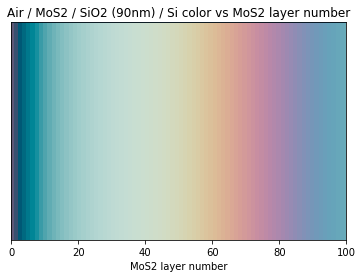

In [30]:
    """
    Color calculations: What color is a graphene / air / SiO2/ Si?  air/SiO2 layers trade off.
    """
    import colorpy.illuminants
    import colorpy.colormodels
    from tmm import color

    # Crystalline silicon refractive index. Data from Palik via
    # http://refractiveindex.info, I haven't checked it, but this is just for
    # demonstration purposes anyway.
    Si_n_data = [[400, 5.57 + 0.387j],
                 [450, 4.67 + 0.145j],
                 [500, 4.30 + 7.28e-2j],
                 [550, 4.08 + 4.06e-2j],
                 [600, 3.95 + 2.57e-2j],
                 [650, 3.85 + 1.64e-2j],
                 [700, 3.78 + 1.26e-2j]]
    Si_n_data = array(Si_n_data)
    Si_n_fn = interp1d(Si_n_data[:,0], Si_n_data[:,1], kind='linear')
    
    MoS2_n_data= [[400,2.40+2.23j],
                  [425,3.32+2.23j],
                  [450,4.38+1.30j],
                  [475,4.49+0.85j],
                  [500,4.75+0.83j],
                  [525,4.50+0.65j],
                  [550,4.20+0.60j],
                  [575,3.82+0.62j],
                  [600,3.99+1.15j],
                  [625,4.42+0.75j],
                  [650,4.40+0.99j],
                  [675,4.50+0.25j],
                  [700,3.90+0.11j],
                  [725,3.56+0.07j],
                  [750,3.25+0.07j]]
    
    MoS2_n_data = np.array(MoS2_n_data)
    MoS2_n_fn = interp1d(MoS2_n_data[:,0], MoS2_n_data[:,1], kind='linear')
    
    # SiO2 refractive index (approximate): 1.46 regardless of wavelength
    SiO2_n_fn = lambda wavelength : 1.46
    # air refractive index
    air_n_fn = lambda wavelength : 1
    
    n_fn_list = [air_n_fn, MoS2_n_fn, SiO2_n_fn, Si_n_fn]
    th_0 = 0
    
    # Calculate irgb color (i.e. gamma-corrected sRGB display color rounded to
    # integers 0-255) versus thickness of SiO2
    max_gap_thickness = 100
    gap_thickness_list = linspace(0,max_gap_thickness,num=80)
    irgb_list = []
    for gap_d in gap_thickness_list:
        d_list = [inf, gap_d*0.79, 90, inf]
        reflectances = color.calc_reflectances(n_fn_list, d_list, th_0)
        illuminant = colorpy.illuminants.get_illuminant_D65()
        spectrum = color.calc_spectrum(reflectances, illuminant)
        color_dict = color.calc_color(spectrum)
        irgb_list.append(color_dict['irgb'])

    # Plot those colors
    print('Making color vs gap thickness graph. ')
    plt.figure()
    plt.plot([0,max_gap_thickness],[1,1])
    plt.xlim(0,max_gap_thickness)
    plt.ylim(0,1)
    plt.xlabel('MoS2 layer number')
    plt.yticks([])
    plt.title('Air / MoS2 / SiO2 (90nm) / Si color vs MoS2 layer number')
    for i in range(len(gap_thickness_list)):
        # One strip of each color, centered at x=SiO2_thickness_list[i]
        if i==0:
            x0 = 0
        else:
            x0 = (gap_thickness_list[i] + gap_thickness_list[i-1]) / 2
        if i == len(gap_thickness_list) - 1:
            x1 = max_gap_thickness
        else:
            x1 = (gap_thickness_list[i] + gap_thickness_list[i+1]) / 2
        y0 = 0
        y1 = 1
        poly_x = [x0,  x1,  x1, x0]
        poly_y = [y0, y0, y1, y1]
        color_string = colorpy.colormodels.irgb_string_from_irgb(irgb_list[i])
        plt.fill(poly_x, poly_y, color_string, edgecolor=color_string)

Making color vs gap thickness graph. 


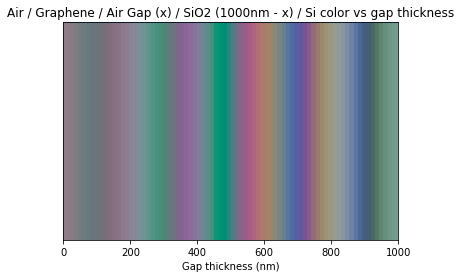

In [31]:
    """
    Color calculations: What color is a graphene / air / SiO2/ Si?  air/SiO2 layers trade off.
    """
    import colorpy.illuminants
    import colorpy.colormodels
    from tmm import color

    # Crystalline silicon refractive index. Data from Palik via
    # http://refractiveindex.info, I haven't checked it, but this is just for
    # demonstration purposes anyway.
    Si_n_data = [[400, 5.57 + 0.387j],
                 [450, 4.67 + 0.145j],
                 [500, 4.30 + 7.28e-2j],
                 [550, 4.08 + 4.06e-2j],
                 [600, 3.95 + 2.57e-2j],
                 [650, 3.85 + 1.64e-2j],
                 [700, 3.78 + 1.26e-2j]]
    Si_n_data = array(Si_n_data)
    Si_n_fn = interp1d(Si_n_data[:,0], Si_n_data[:,1], kind='linear')
    
    MoS2_n_fn= lambda wavelength: 5.2+1.27j
    
    # SiO2 refractive index (approximate): 1.46 regardless of wavelength
    SiO2_n_fn = lambda wavelength : 1.46
    # air refractive index
    air_n_fn = lambda wavelength : 1
    
    n_fn_list = [air_n_fn, MoS2_n_fn, air_n_fn, SiO2_n_fn, Si_n_fn]
    th_0 = 0
    
    # Calculate irgb color (i.e. gamma-corrected sRGB display color rounded to
    # integers 0-255) versus thickness of SiO2
    max_gap_thickness = 1000
    gap_thickness_list = linspace(0,max_gap_thickness,num=80)
    irgb_list = []
    for gap_d in gap_thickness_list:
        d_list = [inf, 0.79, gap_d, 1000-gap_d, inf]
        reflectances = color.calc_reflectances(n_fn_list, d_list, th_0)
        illuminant = colorpy.illuminants.get_illuminant_D65()
        spectrum = color.calc_spectrum(reflectances, illuminant)
        color_dict = color.calc_color(spectrum)
        irgb_list.append(color_dict['irgb'])

    # Plot those colors
    print('Making color vs gap thickness graph. ')
    plt.figure()
    plt.plot([0,max_gap_thickness],[1,1])
    plt.xlim(0,max_gap_thickness)
    plt.ylim(0,1)
    plt.xlabel('Gap thickness (nm)')
    plt.yticks([])
    plt.title('Air / Graphene / Air Gap (x) / SiO2 (1000nm - x) / Si color vs gap thickness')
    for i in range(len(gap_thickness_list)):
        # One strip of each color, centered at x=SiO2_thickness_list[i]
        if i==0:
            x0 = 0
        else:
            x0 = (gap_thickness_list[i] + gap_thickness_list[i-1]) / 2
        if i == len(gap_thickness_list) - 1:
            x1 = max_gap_thickness
        else:
            x1 = (gap_thickness_list[i] + gap_thickness_list[i+1]) / 2
        y0 = 0
        y1 = 1
        poly_x = [x0,  x1,  x1, x0]
        poly_y = [y0, y0, y1, y1]
        color_string = colorpy.colormodels.irgb_string_from_irgb(irgb_list[i])
        plt.fill(poly_x, poly_y, color_string, edgecolor=color_string)

Making color vs gap thickness graph. 


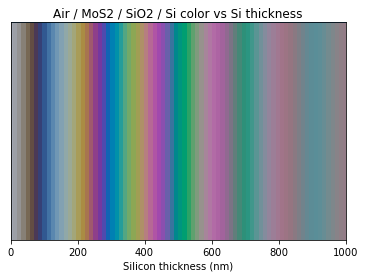

In [32]:
    """
    Color calculations: What color is a MoS2 / air / SiO2/ Si?  air/SiO2 layers trade off.
    """
    import colorpy.illuminants
    import colorpy.colormodels
    from tmm import color

    # Crystalline silicon refractive index. Data from Palik via
    # http://refractiveindex.info, I haven't checked it, but this is just for
    # demonstration purposes anyway.
    Si_n_data = [[400, 5.57 + 0.387j],
                 [450, 4.67 + 0.145j],
                 [500, 4.30 + 7.28e-2j],
                 [550, 4.08 + 4.06e-2j],
                 [600, 3.95 + 2.57e-2j],
                 [650, 3.85 + 1.64e-2j],
                 [700, 3.78 + 1.26e-2j]]
    Si_n_data = array(Si_n_data)
    Si_n_fn = interp1d(Si_n_data[:,0], Si_n_data[:,1], kind='linear')
    
    
    MoS2_n_fn= lambda wavelength : 5.2+1.27j
    
    # SiO2 refractive index (approximate): 1.46 regardless of wavelength
    SiO2_n_fn = lambda wavelength : 1.46
    # air refractive index
    air_n_fn = lambda wavelength : 1
    
    n_fn_list = [air_n_fn, MoS2_n_fn, SiO2_n_fn, Si_n_fn]
    th_0 = 0
    
    # Calculate irgb color (i.e. gamma-corrected sRGB display color rounded to
    # integers 0-255) versus thickness of SiO2
    max_gap_thickness = 1000
    gap_thickness_list = linspace(0,max_gap_thickness,num=80)
    irgb_list = []
    for gap_d in gap_thickness_list:
        d_list = [inf, 0.79, gap_d, inf]
        reflectances = color.calc_reflectances(n_fn_list, d_list, th_0)
        illuminant = colorpy.illuminants.get_illuminant_D65()
        spectrum = color.calc_spectrum(reflectances, illuminant)
        color_dict = color.calc_color(spectrum)
        irgb_list.append(color_dict['irgb'])

    # Plot those colors
    print('Making color vs gap thickness graph. ')
    plt.figure()
    plt.plot([0,1000],[1,1])
    plt.xlim(0,1000)
    plt.ylim(0,1)
    plt.xlabel('Silicon thickness (nm)')
    plt.yticks([])
    plt.title('Air / MoS2 / SiO2 / Si color vs Si thickness')
    for i in range(len(gap_thickness_list)):
        # One strip of each color, centered at x=SiO2_thickness_list[i]
        if i==0:
            x0 = 0
        else:
            x0 = (gap_thickness_list[i] + gap_thickness_list[i-1]) / 2
        if i == len(gap_thickness_list) - 1:
            x1 = max_gap_thickness
        else:
            x1 = (gap_thickness_list[i] + gap_thickness_list[i+1]) / 2
        y0 = 0
        y1 = 1
        poly_x = [x0,  x1,  x1, x0]
        poly_y = [y0, y0, y1, y1]
        color_string = colorpy.colormodels.irgb_string_from_irgb(irgb_list[i])
        plt.fill(poly_x, poly_y, color_string, edgecolor=color_string)

Making color vs gap thickness graph. 


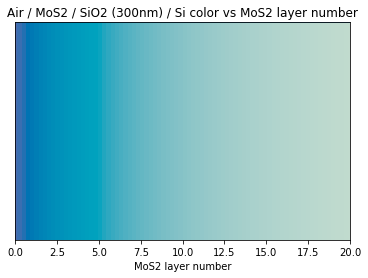

In [33]:
    """
    Color calculations: What color is a graphene / air / SiO2/ Si?  air/SiO2 layers trade off.
    """
    import colorpy.illuminants
    import colorpy.colormodels
    from tmm import color

    # Crystalline silicon refractive index. Data from Palik via
    # http://refractiveindex.info, I haven't checked it, but this is just for
    # demonstration purposes anyway.
    Si_n_data = [[400, 5.57 + 0.387j],
                 [450, 4.67 + 0.145j],
                 [500, 4.30 + 7.28e-2j],
                 [550, 4.08 + 4.06e-2j],
                 [600, 3.95 + 2.57e-2j],
                 [650, 3.85 + 1.64e-2j],
                 [700, 3.78 + 1.26e-2j]]
    Si_n_data = array(Si_n_data)
    Si_n_fn = interp1d(Si_n_data[:,0], Si_n_data[:,1], kind='linear')
    
    
    
    # SiO2 refractive index (approximate): 1.46 regardless of wavelength
    SiO2_n_fn = lambda wavelength : 1.46
    # air refractive index
    air_n_fn = lambda wavelength : 1
    
    MoS2_n_fn= lambda wavelength : 5.2+1.27j
    
    n_fn_list = [air_n_fn, MoS2_n_fn, SiO2_n_fn, Si_n_fn]
    th_0 = 0
    
    # Calculate irgb color (i.e. gamma-corrected sRGB display color rounded to
    # integers 0-255) versus thickness of SiO2
    max_gap_thickness = 20
    gap_thickness_list = linspace(0,max_gap_thickness,num=80)
    irgb_list = []
    for gap_d in gap_thickness_list:
        d_list = [inf, gap_d*0.79, 300, inf]
        reflectances = color.calc_reflectances(n_fn_list, d_list, th_0)
        illuminant = colorpy.illuminants.get_illuminant_D65()
        spectrum = color.calc_spectrum(reflectances, illuminant)
        color_dict = color.calc_color(spectrum)
        irgb_list.append(color_dict['irgb'])

    # Plot those colors
    print('Making color vs gap thickness graph. ')
    plt.figure()
    plt.plot([0,max_gap_thickness],[1,1])
    plt.xlim(0,max_gap_thickness)
    plt.ylim(0,1)
    plt.xlabel('MoS2 layer number')
    plt.yticks([])
    plt.title('Air / MoS2 / SiO2 (300nm) / Si color vs MoS2 layer number')
    for i in range(len(gap_thickness_list)):
        # One strip of each color, centered at x=SiO2_thickness_list[i]
        if i==0:
            x0 = 0
        else:
            x0 = (gap_thickness_list[i] + gap_thickness_list[i-1]) / 2
        if i == len(gap_thickness_list) - 1:
            x1 = max_gap_thickness
        else:
            x1 = (gap_thickness_list[i] + gap_thickness_list[i+1]) / 2
        y0 = 0
        y1 = 1
        poly_x = [x0,  x1,  x1, x0]
        poly_y = [y0, y0, y1, y1]
        color_string = colorpy.colormodels.irgb_string_from_irgb(irgb_list[i])
        plt.fill(poly_x, poly_y, color_string, edgecolor=color_string)

Making color vs gap thickness graph. 


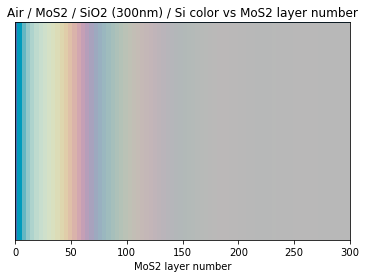

In [34]:
    """
    Color calculations: What color is a graphene / air / SiO2/ Si?  air/SiO2 layers trade off.
    """
    import colorpy.illuminants
    import colorpy.colormodels
    from tmm import color

    # Crystalline silicon refractive index. Data from Palik via
    # http://refractiveindex.info, I haven't checked it, but this is just for
    # demonstration purposes anyway.
    Si_n_data = [[400, 5.57 + 0.387j],
                 [450, 4.67 + 0.145j],
                 [500, 4.30 + 7.28e-2j],
                 [550, 4.08 + 4.06e-2j],
                 [600, 3.95 + 2.57e-2j],
                 [650, 3.85 + 1.64e-2j],
                 [700, 3.78 + 1.26e-2j]]
    Si_n_data = array(Si_n_data)
    Si_n_fn = interp1d(Si_n_data[:,0], Si_n_data[:,1], kind='linear')
    
    MoS2_n_fn= lambda wavelength : 5.2+1.27j
    
    # SiO2 refractive index (approximate): 1.46 regardless of wavelength
    SiO2_n_fn = lambda wavelength : 1.46
    # air refractive index
    air_n_fn = lambda wavelength : 1
    
    n_fn_list = [air_n_fn, MoS2_n_fn, SiO2_n_fn, Si_n_fn]
    th_0 = 0
    
    # Calculate irgb color (i.e. gamma-corrected sRGB display color rounded to
    # integers 0-255) versus thickness of SiO2
    max_gap_thickness = 300
    gap_thickness_list = linspace(0,max_gap_thickness,num=80)
    irgb_list = []
    for gap_d in gap_thickness_list:
        d_list = [inf, gap_d*0.79, 300, inf]
        reflectances = color.calc_reflectances(n_fn_list, d_list, th_0)
        illuminant = colorpy.illuminants.get_illuminant_D65()
        spectrum = color.calc_spectrum(reflectances, illuminant)
        color_dict = color.calc_color(spectrum)
        irgb_list.append(color_dict['irgb'])

    # Plot those colors
    print('Making color vs gap thickness graph. ')
    plt.figure()
    plt.plot([0,max_gap_thickness],[1,1])
    plt.xlim(0,max_gap_thickness)
    plt.ylim(0,1)
    plt.xlabel('MoS2 layer number')
    plt.yticks([])
    plt.title('Air / MoS2 / SiO2 (300nm) / Si color vs MoS2 layer number')
    for i in range(len(gap_thickness_list)):
        # One strip of each color, centered at x=SiO2_thickness_list[i]
        if i==0:
            x0 = 0
        else:
            x0 = (gap_thickness_list[i] + gap_thickness_list[i-1]) / 2
        if i == len(gap_thickness_list) - 1:
            x1 = max_gap_thickness
        else:
            x1 = (gap_thickness_list[i] + gap_thickness_list[i+1]) / 2
        y0 = 0
        y1 = 1
        poly_x = [x0,  x1,  x1, x0]
        poly_y = [y0, y0, y1, y1]
        color_string = colorpy.colormodels.irgb_string_from_irgb(irgb_list[i])
        plt.fill(poly_x, poly_y, color_string, edgecolor=color_string)

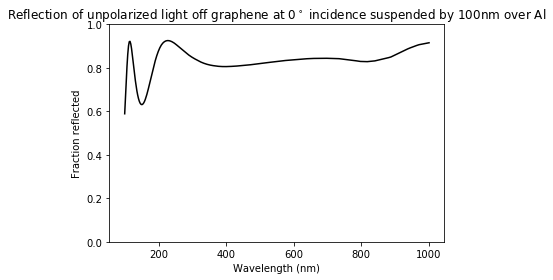

In [35]:
    """
    Plot the reflectivity of a single layer of graphene suspended over aluminum.
    
    """
    # list of layer thicknesses in nm
    d_list = [inf,0.34,100,inf]
    # list of refractive indices
    n_list = [1,2.6+1.3j,1]
    lamb=np.linspace(100,1000,num=400)
    # initialize lists of y-values to plot
    Rnorm=[] 
    
    for l in lamb:
		# For normal incidence, s and p polarizations are identical.
		# I arbitrarily decided to use 's'.
        n_list = [1,2.6+1.3j,1,al_n_fn(l)]
        Rnorm.append(tmm.tmm_core.coh_tmm('s',n_list, d_list, 0, l)['R'])
    
   
    p=plt.plot(lamb,Rnorm,'black')
    plt.ylim([0,1])
   
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Fraction reflected')
    plt.title('Reflection of unpolarized light off graphene at 0$^\circ$ incidence suspended by 100nm over Al')
    plt.show()

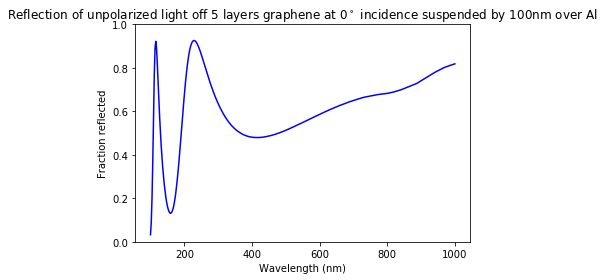

In [36]:
    """
    Plot the reflectivity of 5 layers of graphene suspended over aluminum.
    
    """
    # list of layer thicknesses in nm
    d_list = [inf,5*0.34,100,inf]
    # list of refractive indices

    lamb=np.linspace(100,1000,num=400)
    # initialize lists of y-values to plot
    Rnorm=[] 
    
    for l in lamb:
		# For normal incidence, s and p polarizations are identical.
		# I arbitrarily decided to use 's'.
        n_list = [1,2.6+1.3j,1,al_n_fn(l)]
        Rnorm.append(tmm.tmm_core.coh_tmm('s',n_list, d_list, 0, l)['R'])
    
   
    plt.plot(lamb,Rnorm,'blue')
    plt.ylim([0,1])
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Fraction reflected')
    plt.title('Reflection of unpolarized light off 5 layers graphene at 0$^\circ$ incidence suspended by 100nm over Al')
    plt.show()

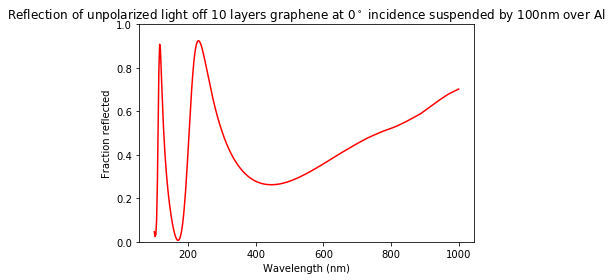

In [37]:
    """
    Plot the reflectivity of 10 layers of graphene suspended over aluminum.
    
    """
    # list of layer thicknesses in nm
    d_list = [inf,10*0.34,100,inf]
    # list of refractive indices

    lamb=np.linspace(100,1000,num=400)
    # initialize lists of y-values to plot
    Rnorm=[] 
    
    for l in lamb:
		# For normal incidence, s and p polarizations are identical.
		# I arbitrarily decided to use 's'.
        n_list = [1,2.6+1.3j,1,al_n_fn(l)]
        Rnorm.append(tmm.tmm_core.coh_tmm('s',n_list, d_list, 0, l)['R'])
    
   
    plt.plot(lamb,Rnorm,'red')
    plt.ylim([0,1])
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Fraction reflected')
    plt.title('Reflection of unpolarized light off 10 layers graphene at 0$^\circ$ incidence suspended by 100nm over Al')
    plt.show()

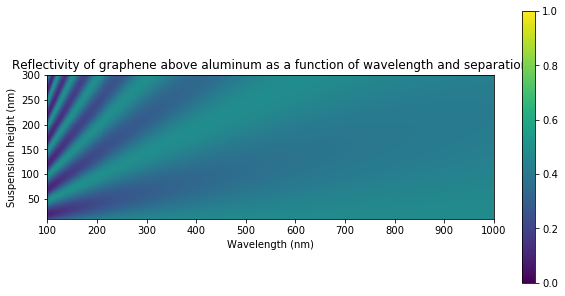

In [38]:
"""
    Plot the reflectivity of graphene suspended over aluminum.
    
"""

lamb=np.linspace(100,1000,num=451)
susp = np.linspace(10,300,num=291)
# initialize lists of y-values to plot
Rnorm=[] 
TwoDR=np.zeros((291,451))
a=0

for s in susp:
    b=0
    for l in lamb:
        n_list = [1,2.6+1.3j,1,MoS2_n_fn(l)]
        d_list = [inf,0.79,s,inf]
        TwoDR[a,b] = tmm.tmm_core.coh_tmm('s',n_list, d_list, 0, l)['R']
        b = b+1
    a=a+1
    
    
plt.figure(figsize=(10,5))
plt.subplot(111)
plt.title("Reflectivity of graphene above aluminum as a function of wavelength and separation")
plt.imshow(TwoDR, interpolation="nearest", origin="lower",extent=[100,1000,10,300],vmin=0,vmax=1)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Suspension height (nm)')
plt.colorbar()
plt.show()


In [39]:
print(lamb[2]-lamb[1])

print(susp[2]-susp[1])

2.0
1.0


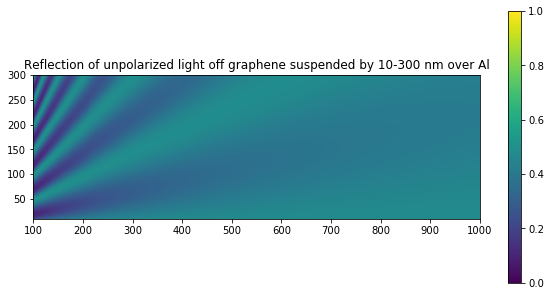

In [40]:
plt.figure(figsize=(10,5))
plt.subplot(111)
plt.imshow(TwoDR, interpolation="nearest", origin="lower",extent=[100,1000,10,300],vmin=0,vmax=1)
plt.colorbar()
plt.title('Reflection of unpolarized light off graphene suspended by 10-300 nm over Al')
plt.show()

In [41]:
sensitivity = np.gradient(TwoDR,1, axis=1)

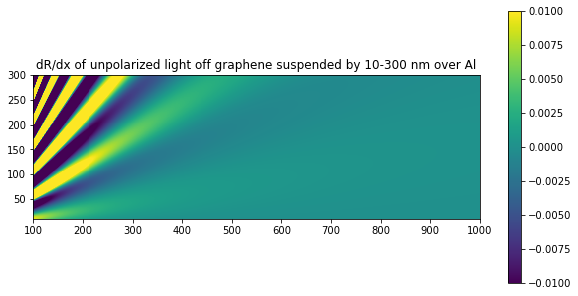

In [42]:
plt.figure(figsize=(10,5))
plt.subplot(111)
plt.imshow(sensitivity, interpolation="nearest", origin="lower",extent=[100,1000,10,300],vmin=-0.01,vmax=0.01)
plt.colorbar()
plt.title('dR/dx of unpolarized light off graphene suspended by 10-300 nm over Al')
plt.show()

In [43]:
sensitivity = np.gradient(TwoDR,[2,1],axis=1)


plt.plot(susp,TwoDR[:,200],'black')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Fraction reflected')
plt.title('Reflection of unpolarized light off 10 layers graphene at 0$^\circ$ incidence suspended by 100nm over Al')
plt.show()

ValueError: distances must be scalars

In [ ]:
"""
    Plot the reflectivity of 10 layers graphene suspended over aluminum.
    
"""

lamb=np.linspace(100,1000,num=400)
susp = np.linspace(10,300,num=290)
# initialize lists of y-values to plot
Rnorm=[] 
TwoDR=np.zeros((290,400))
a=0

for s in susp:
    b=0
    for l in lamb:
        n_list = [1,2.6+1.3j,1,al_n_fn(l)]
        d_list = [inf,10*0.34,s,inf]
        TwoDR[a,b] = tmm.tmm_core.coh_tmm('s',n_list, d_list, 0, l)['R']
        b = b+1
    a=a+1
    
plt.figure(figsize=(10,5))
plt.subplot(111)
plt.imshow(TwoDR, interpolation="nearest", origin="lower",extent=[100,1000,10,300],vmin=0,vmax=1)
plt.colorbar()
plt.title('Reflection of unpolarized light off 10L graphene suspended by 10-300 nm over Al')
plt.show()

print(lamb[200])
plt.plot(susp,TwoDR[:,200],'black')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Fraction reflected')
plt.title('Reflection of unpolarized light off 10 layers graphene at 0$^\circ$ incidence suspended by 100nm over Al')
plt.show()

In [ ]:
lamb=np.linspace(100,1000,num=400)
susp = np.linspace(10,300,num=290)
# initialize lists of y-values to plot
Rnorm=[] 
TwoDR=np.zeros((290,400))
a=0

for s in susp:
    b=0
    for l in lamb:
        n_list = [1,2.6+1.3j,1,al_n_fn(l)]
        d_list = [inf,5*0.34,s,inf]
        TwoDR[a,b] = tmm.tmm_core.coh_tmm('s',n_list, d_list, 0, l)['R']
        b = b+1
    a=a+1
    
plt.figure(figsize=(10,5))
plt.subplot(111)
plt.imshow(TwoDR, interpolation="nearest", origin="lower",extent=[100,1000,10,300],vmin=0,vmax=1)
plt.colorbar()
plt.title('Reflection of unpolarized light off 5L graphene suspended by 10-300 nm over Al')
plt.show()

print(lamb[200])
plt.plot(susp,TwoDR[:,200],'black')
plt.xlabel('Suspension height (nm)')
plt.ylabel('Fraction reflected')
plt.title('Reflection of unpolarized light off 5 layers graphene at 550nm suspended over Al')
plt.show()